# Аналитика в Яндекс.Афише
## Описание проекта

Исходные данные: данные интернет-сервиса по продаже билетов Яндекс.Афиша с июня 2017 по конец мая 2018 года.

Цель - изучить поведение пользователей и рассчитать бизнес-метрики, чтобы выработать на их основе рекомендации по оптимизации маркетинговых затрат: куда и сколько вкладывать денег, в какие источники/платформы.

## Оглавление
* [Шаг 1. Загрузка данных и подготовка их к анализу](#h1_1)
* [Шаг 2. Построение отчётов и расчет метрик](#h1_2)
    * [2.1. Продукт](#h2_2_1)
    * [2.2. Покупки](#h2_2_2)
    * [2.3. Маркетинг](#h2_2_3)
* [Шаг 3. Общий вывод](#h1_3)

### Общие функции для работы с данными

In [3]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

# Функция print_plot для вывода графиков
#  - data - датафрейм или колонка
#  - kind - тип графика
#  - plot_title - заголовок графика
#  - x_name - название оси абсцисс
#  - y_name - названи оси ординат
def print_plot(data, kind, plot_title, x_name, y_name, linewidth=3):
    data.plot(kind=kind, grid=True, figsize=(12, 5))
    plt.title(plot_title)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()

# Функция print_heatmap для вывода тепловой карты
#  - data - датафрейм
#  - plot_title - заголовок графика
#  - fmt - правила форматирования содержимого ячеек
#  - vmax - значение для самого "горячего" цвета ячейки
#  - x_name - название оси абсцисс
#  - y_name - названи оси ординат
def print_heatmap(data, plot_title, fmt, vmax, x_name, y_name):   
    yticks = data.index
    sns.set(style='white')
    plt.figure(figsize=(12,7))
    plt.title(plot_title)
    sns.heatmap(data, annot=True, fmt=fmt, vmax=vmax, linewidth=0.01, yticklabels = yticks, linecolor = 'gray')
    plt.yticks(rotation=0)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()
    
# Улучшение четкости изображения
%config InlineBackend.figure_format = 'retina'

# Отключение предупреждений SettingWithCopyWarning
pd.options.mode.chained_assignment = None

## Шаг 1. Загрузка данных и подготовка их к анализу<a class="anchor" id="h1_1"></a>
На данном шаге сделаем следующее:
* Загрузим данные о визитах, заказах и расходах в переменные.
* Оптимизируем данные для анализа.
* Убедимся, что тип данных в каждой колонке — правильный.

In [4]:
# Открытие файлов и создание датафреймов
visits = pd.read_csv('visits_log.csv')
orders = pd.read_csv('orders_log.csv')
costs = pd.read_csv('costs.csv')

### Данные о посещениях (`visits`)
Посмотрим общую информацию и примеры данных:

In [5]:
visits.info()
visits

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


Сначала переименуем столбцы в более удобный для работы вид: заменим пробелы на знак подчеркивания, а прописные буквы заменим на строчные.

In [6]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

Далее переведем значения столбцов `end_ts` и `start_ts` в формат datetime.

In [7]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

Посмотрим, нет ли аномалий в датафрейме. Рассчитаем длительность сессии, добавив новый столбец `visit_duration`:

In [8]:
visits['visit_duration'] = ((visits['end_ts'] - visits['start_ts']).dt.seconds / 60).astype('int')

Посмотрим, есть ли записи с длиной сессии, равной нулю:

In [9]:
visits[visits['visit_duration'] == 0] 

,device,end_ts,source_id,start_ts,uid,visit_duration
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,0
28,desktop,2017-11-09 15:53:00,4,2017-11-09 15:53:00,17892541477379911957,0
32,desktop,2017-11-30 12:29:00,4,2017-11-30 12:29:00,13410401624913285510,0
54,desktop,2018-02-23 16:52:00,10,2018-02-23 16:52:00,13423278602430425332,0
...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,0
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,0
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,0
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,0


Видимо это за сессии, которые длились меньше одной минуты. Поэтому не будем удалять эти записи из набора данных.

### Данные о заказах (`orders`)
Посмотрим общую информацию и примеры данных:

In [10]:
orders.info()
orders

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


Также переименуем столбцы аналогично предыдущему датасету.

In [11]:
orders.columns = ['buy_ts', 'revenue', 'uid']

Переведем значения столбца `buy_ts` в формат datetime.

In [12]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

Посмотрим, есть ли заказы с нулевой выручкой:

In [13]:
orders[orders['revenue'] == 0].count()

buy_ts     51
revenue    51
uid        51
dtype: int64

Удалим записи с нулевой выручкой:

In [14]:
orders = orders[orders['revenue'] > 0]

### Данные о затратах на маркетинг (`costs`)
Посмотрим общую информацию и примеры данных:

In [15]:
costs.info()
costs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


Переведем значения столбца `dt` в формат datetime.

In [16]:
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')

Проверим, есть ли записи с нулевым затратами на маркетинг:

In [17]:
costs[costs['costs'] == 0]

,source_id,dt,costs


Таких записей нет, все в порядке.

## Шаг 2. Построение отчётов и расчет метрик <a class="anchor" id="h1_2"></a>
### 2.1. Продукт <a class="anchor" id="h2_2_1"></a>
Вопросы, на которые требуется ответить в данном пункте:
* Сколько людей пользуются в день, неделю, месяц?
* Сколько сессий в день?
* Сколько длится одна сессия?
* Как часто люди возвращаются?

Выясним, сколько уникальных пользователей используют сервис в день, неделю, месяц. Рассчитаем параметры:
* DAU (от англ. daily active users) — количество уникальных пользователей в день;
* WAU (от англ. weekly active users) — количество уникальных пользователей в неделю;
* MAU (от англ. monthly active users) — количество уникальных пользователей в месяц.

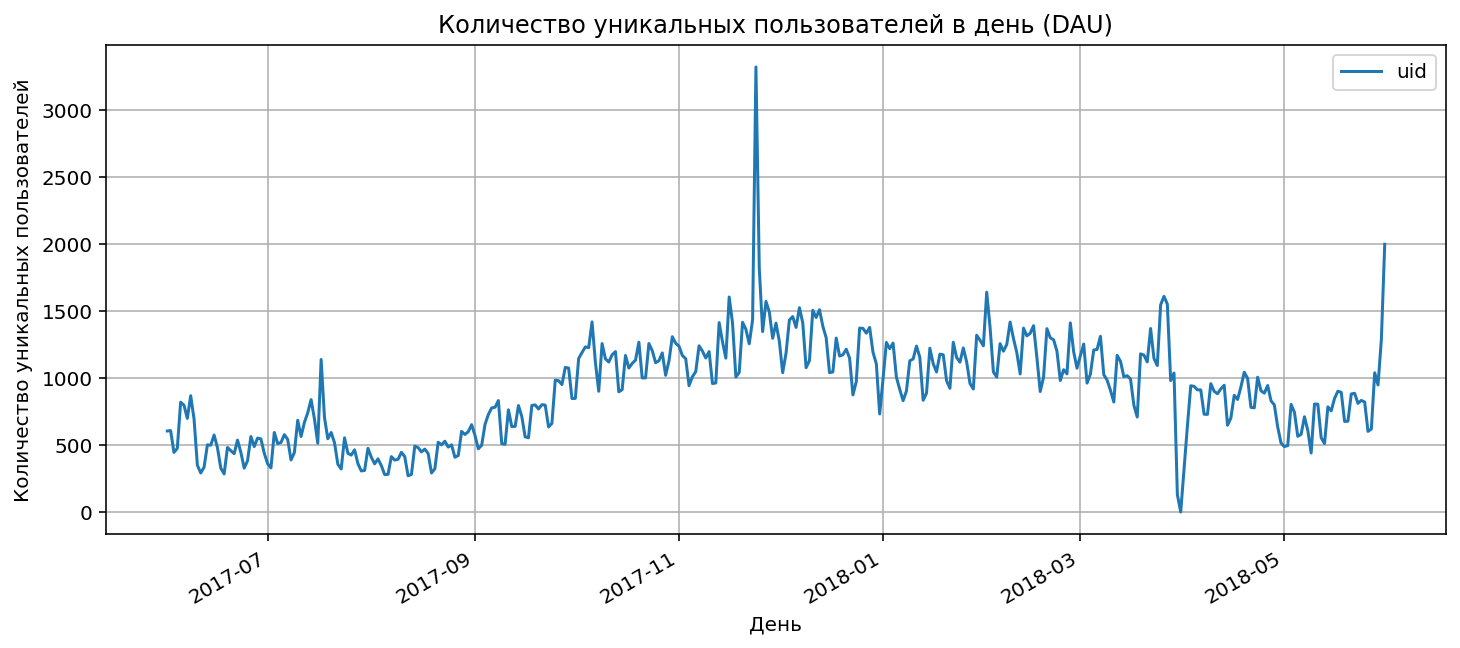

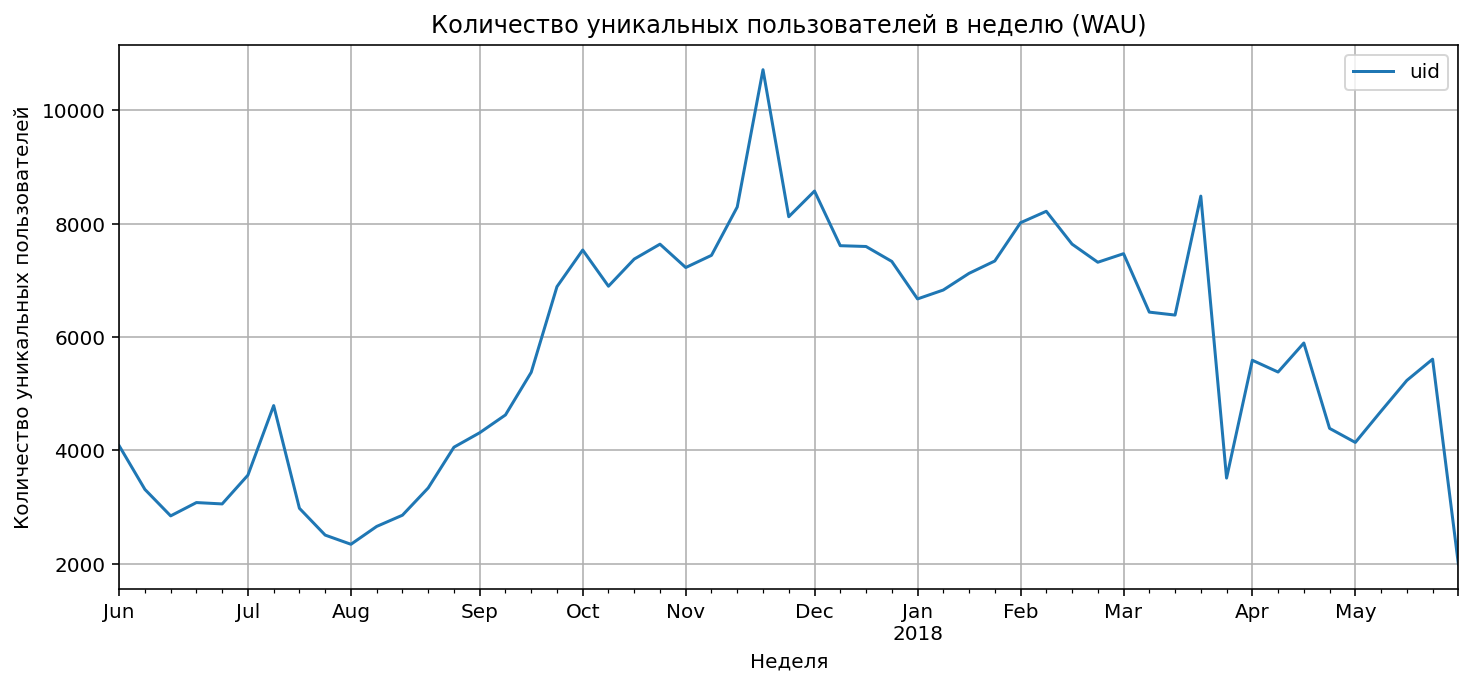

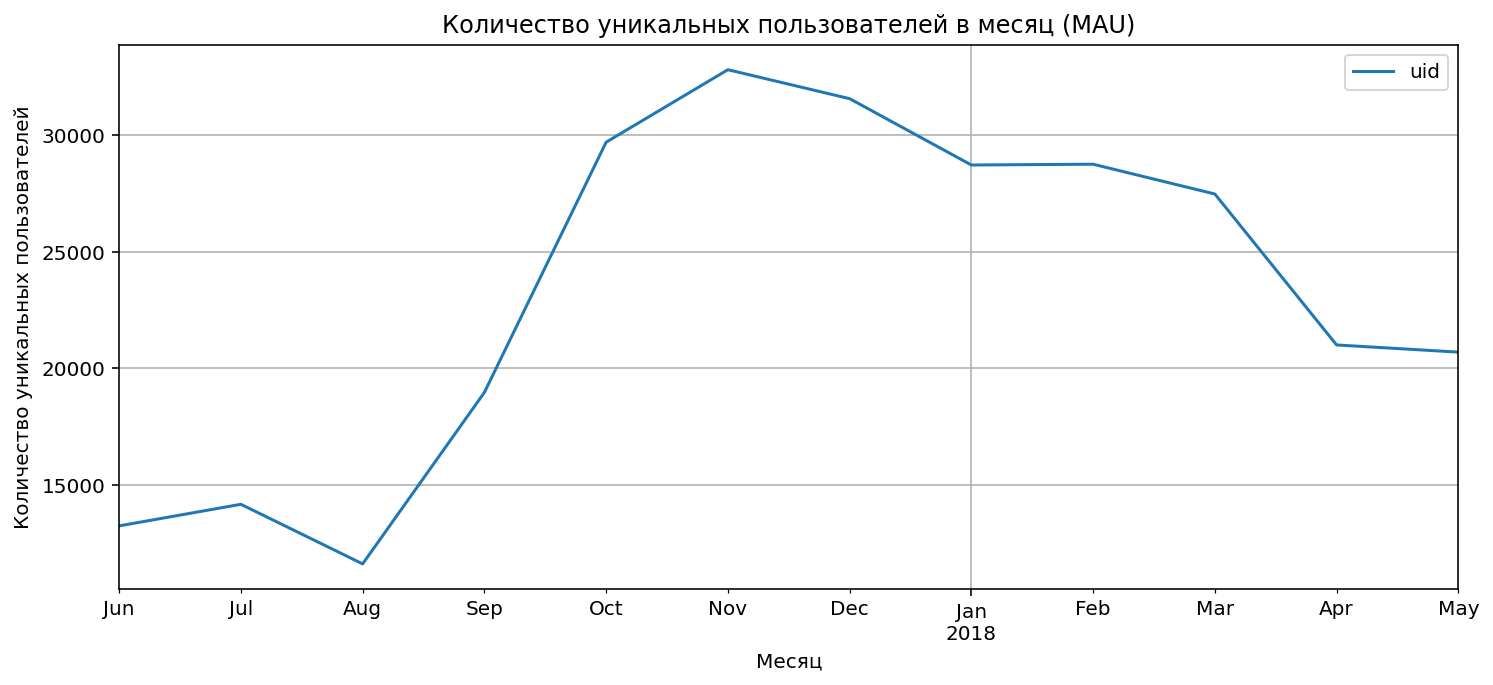

In [18]:
# Добавление в датафрейм visits столбцов с днем, неделей и месяцем начала сессии
visits['date'] = visits['start_ts'].astype('datetime64[D]')
visits['week'] = visits['start_ts'].astype('datetime64[W]')
visits['month'] = visits['start_ts'].astype('datetime64[M]')

# Расчет и построение графика DAU
print_plot(visits.groupby('date')[['uid']].nunique(), 
           'line', 'Количество уникальных пользователей в день (DAU)', 'День', 'Количество уникальных пользователей')

# Расчет и построение графика WAU
print_plot(visits.groupby('week')[['uid']].nunique(), 
           'line', 'Количество уникальных пользователей в неделю (WAU)', 'Неделя', 'Количество уникальных пользователей')

# Расчет и построение графика MAU
print_plot(visits.groupby('month')[['uid']].nunique(), 
           'line', 'Количество уникальных пользователей в месяц (MAU)', 'Месяц', 'Количество уникальных пользователей')

In [49]:
visits.groupby('date')[['uid']].nunique()

,uid
date,
2017-06-01,605
2017-06-02,608
2017-06-03,445
2017-06-04,476
2017-06-05,820
...,...
2018-05-27,620
2018-05-28,1039
2018-05-29,948


* Видно, что количество сессий в период с октября 2017 по апрель 2018 больше, чем в остальные периоды.
* На дневном графике четко видны колебания активности пользователей в зависимости от дня недели.
* На дневном и недельном графике четко видны несколько локальных пиков и падений. Особенно здесь выделется пик в середине ноября 2017 года и падение в конце апреля 2018 года. При наличии большей информации можно их исследовать с целью выяснить, что вызвало у пользователей повышенный или пониженный интерес к сервису
* На недельном и месячном графиках хорошо видны колебания посещаемости по сезонам. Весной и летом посещаемость намного меньше, чем в осенью и зимой. По-видимому это связано весной и летом люди берут отпуска, ездят за город и в туристические поездки. А поесещение театров, концертов и других культурных мероприятий отходит на второй план.

Далее рассчитаем средние значения показателей DAU, WAU, MAU:

In [19]:
dau_total = visits.groupby(['date']).agg({'uid':'nunique'}).mean()['uid']
wau_total = visits.groupby(['week']).agg({'uid':'nunique'}).mean()['uid']
mau_total = visits.groupby(['month']).agg({'uid':'nunique'}).mean()['uid']
print('Среднее количество уникальных пользователей:')
print('В день (DAU): {:.0f}'.format(dau_total))
print('В неделю (WAU): {:.0f}'.format(wau_total))
print('В месяц (MAU): {:.0f}'.format(mau_total))

Среднее количество уникальных пользователей:
В день (DAU): 908
В неделю (WAU): 5724
В месяц (MAU): 23228


#### Количество сессий в день

Посчитаем количество сессий в день и выведем данный показатель на график вместе с количеством уникальных пользователей в день.

Среднее количество сессий в день: 987


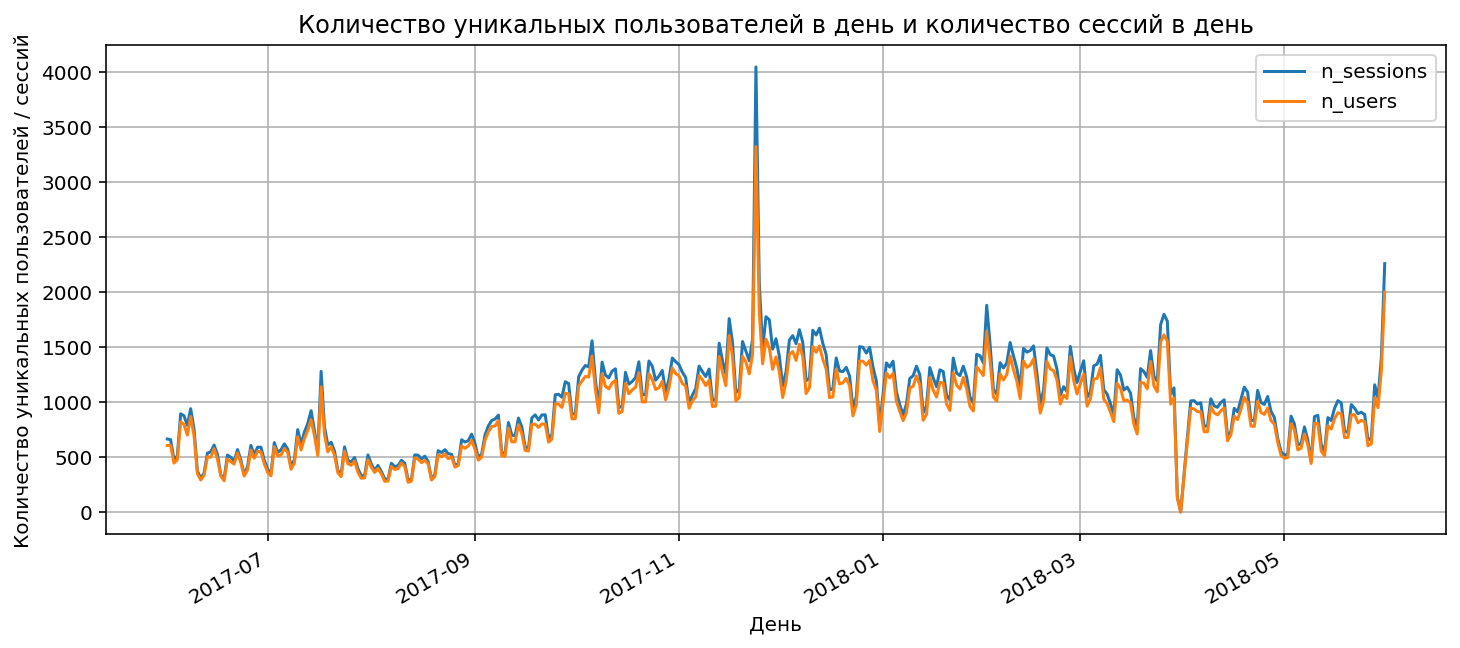

In [20]:
# Количество уникальных пользователей в день и количество сессий в день
sessions_per_user = visits.groupby(['date']).agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user_avg = sessions_per_user['n_sessions'].mean()
print('Среднее количество сессий в день: {:.0f}'.format(sessions_per_user_avg))

# Построение графика
print_plot(sessions_per_user, 
           'line', 'Количество уникальных пользователей в день и количество сессий в день', 'День', 'Количество уникальных пользователей / сессий')

Оба графика практически повторяют друг друга. Т.е. пользователи редко когда заходят чаще, чем раз в день. Чтобы это показать более наглядно, рассчитаем среднее количество сессий на одного пользователя в день и выведем полученные значения в виде графика.

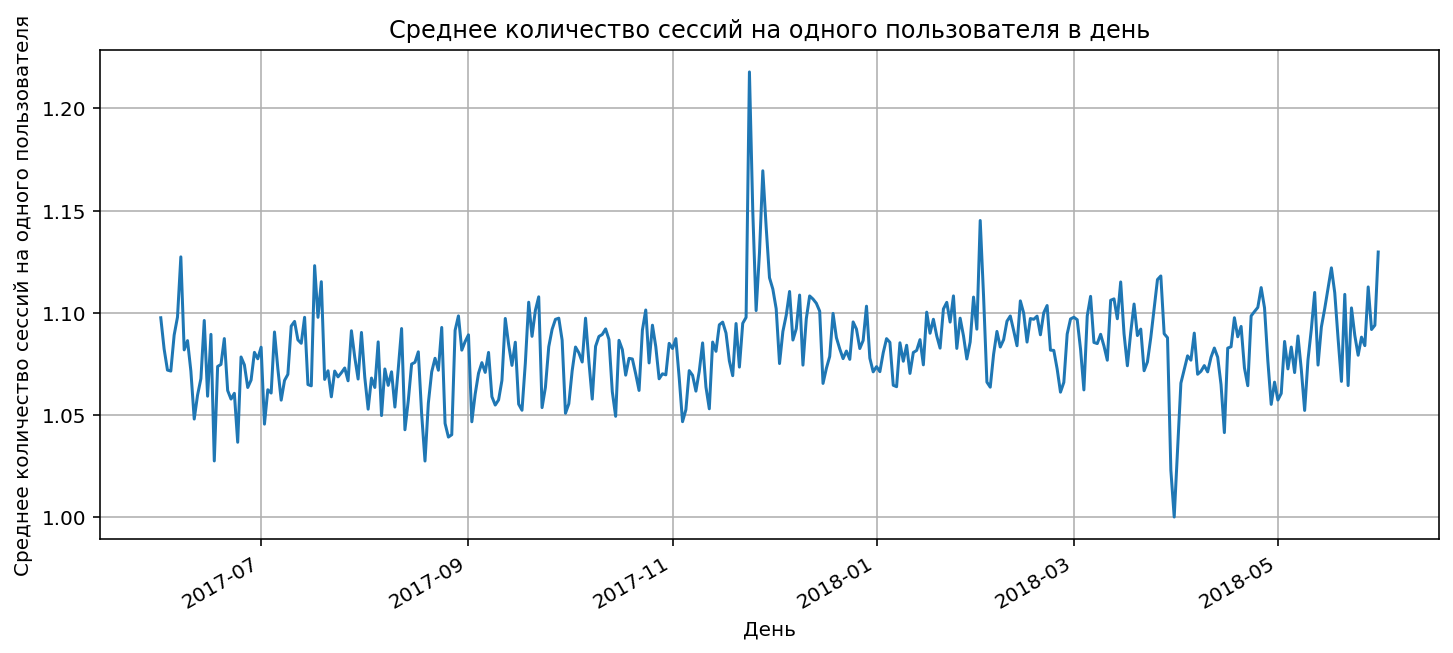

In [21]:
# Среднее количество сессий на одного пользователя в день
sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']

# Построение графика
print_plot(sessions_per_user['sess_per_user'], 
           'line', 'Среднее количество сессий на одного пользователя в день', 'День', 'Среднее количество сессий на одного пользователя')

In [22]:
print('Среднее количество сессий на одного пользователя в день: {:.2f}'.format(sessions_per_user['sess_per_user'].mean()))

Среднее количество сессий на одного пользователя в день: 1.08


#### Количество сессий в разрезе устройств и рекламных источников


Рассчитаем количество сессий в день в разрезе устройств:

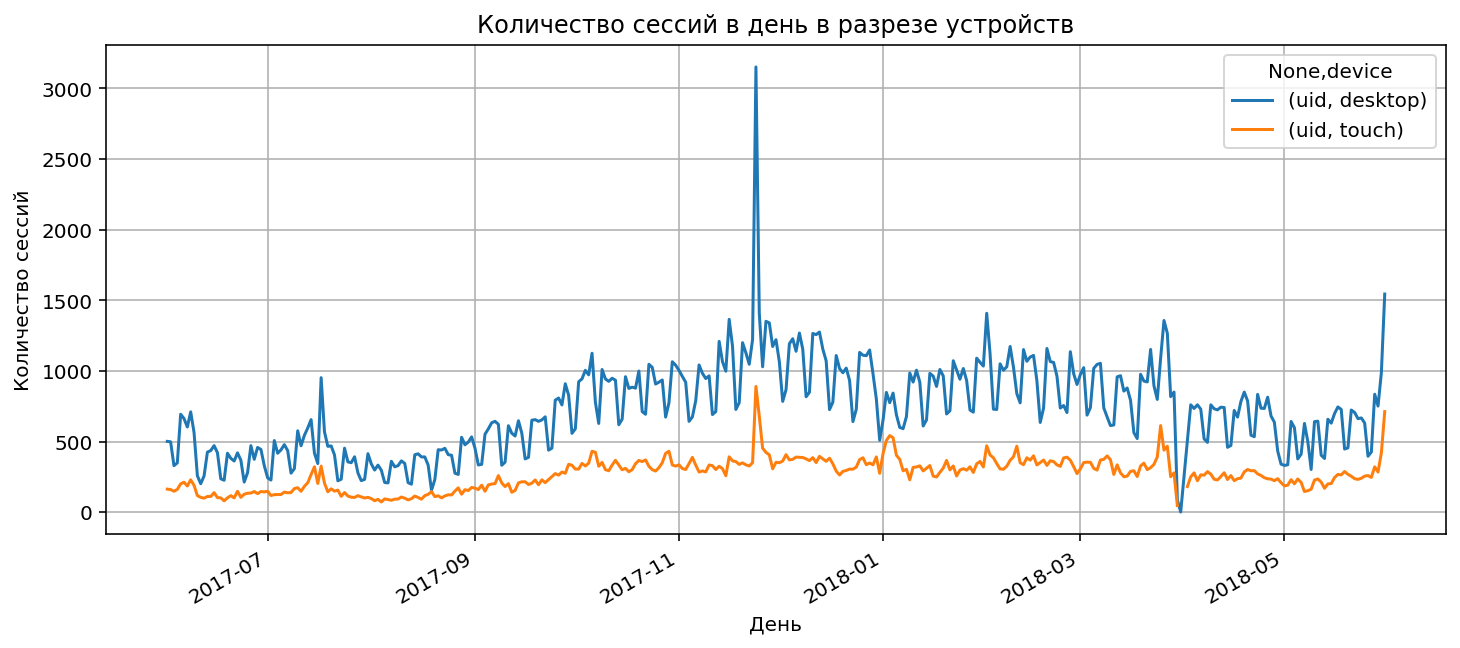

In [23]:
print_plot(visits.groupby(['date','device']).agg({'uid': 'count'}).unstack(), 
           'line', 'Количество сессий в день в разрезе устройств', 'День', 'Количество сессий')

По графику видно, что количество сессий для устройств типа desktop значетельно выше, чем для устройств типа touch.

Рассчитаем среднее количество сессий по каждому типу устройства в день, неделю и месяц.

In [24]:
periods = ['date','week','month']
device_types = ['desktop','touch']
sessions_device = pd.DataFrame()
for device_type in device_types:
    for period in periods:
        sessions_device.loc[period,device_type]  = visits[visits['device'] == device_type].groupby(period)[['uid']].count()['uid'].mean()
sessions_device['sum'] =  sessions_device['desktop'] + sessions_device['touch']
sessions_device['desktop_share'] = sessions_device['desktop'] / sessions_device['sum']
display(sessions_device)

,desktop,touch,sum,desktop_share
date,721.337912,266.757576,988.095488,0.730029
week,4954.094340,1827.037736,6781.132075,0.730570
month,21880.583333,8069.416667,29950.000000,0.730570


По всем периодам получается, что доля устройств desktop составляет примерно 73% от общего количества посещений.

Рассчитаем среднее количество сессий в разрезе источников.

In [25]:
sources = visits['source_id'].unique()
sessions_source = ['desktop','touch']
sessions_source = pd.DataFrame()
for source in sources:
    for period in periods:
        sessions_source.loc[source,period]  = visits[visits['source_id'] == source].groupby(period)[['uid']].count()['uid'].mean()
display(sessions_source)


,date,week,month
4,280.424242,1920.641509,8482.833333
2,131.201102,898.603774,3968.833333
5,184.311295,1262.358491,5575.416667
9,36.575758,250.509434,1106.416667
3,235.840220,1615.283019,7134.166667
1,93.739011,643.792453,2843.416667
10,27.617080,189.150943,835.416667
7,1.058824,1.440000,3.000000
6,1.000000,1.000000,1.000000


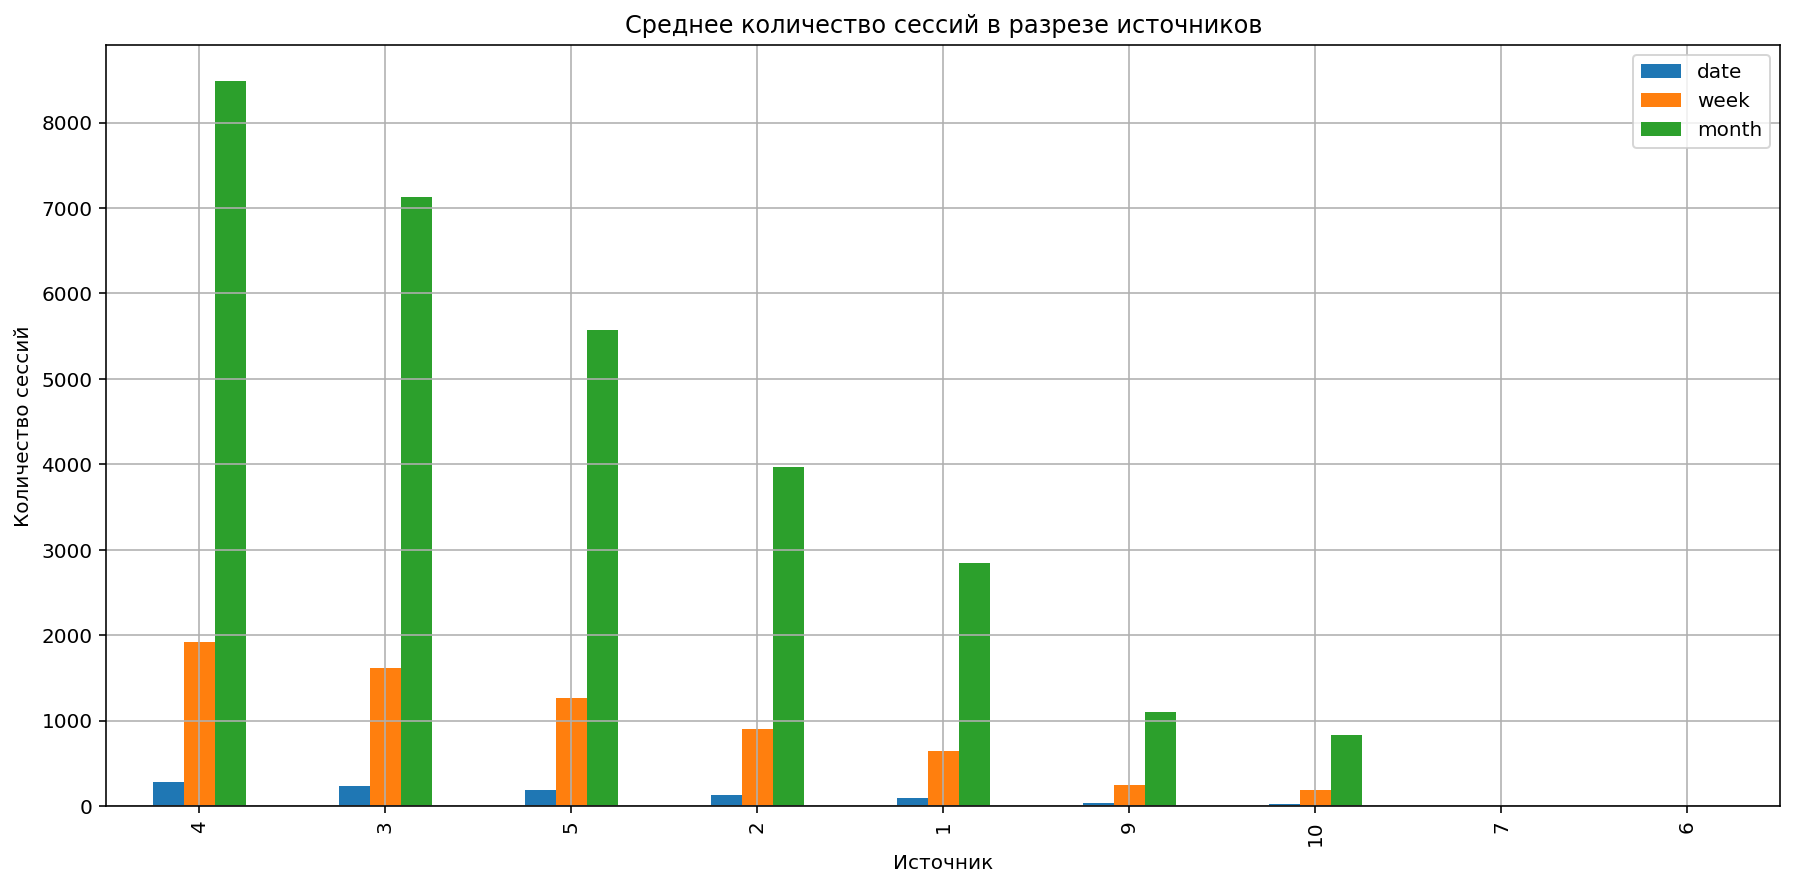

In [26]:
sessions_source.sort_values(by='date', ascending=False).plot(kind='bar', grid=True, figsize=(15, 7))
plt.title('Среднее количество сессий в разрезе источников')
plt.xlabel('Источник')
plt.ylabel('Количество сессий')
plt.show()

Больше всего посещений получается от следующих источников (в порядке убывания): 4, 3, 5, 2.

Покажем наглядно долю каждого источника.

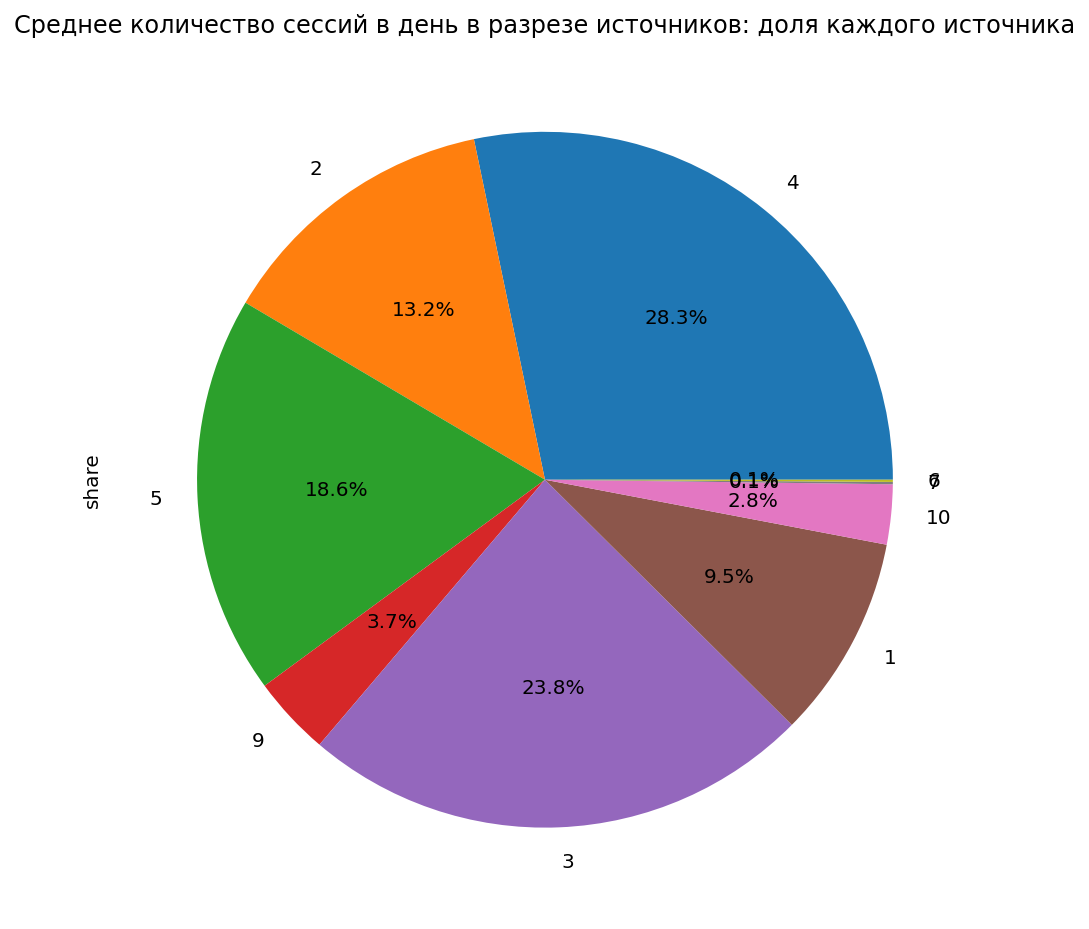

In [27]:
sessions_source['share'] = sessions_source['date'] / sessions_per_user_avg
display(sessions_source['share']
        .plot(kind='pie', title='Среднее количество сессий в день в разрезе источников: доля каждого источника', grid=True, figsize=(8, 8), autopct='%1.1f%%')
)

#### Длительность одной сессии
Данный параметр мы уже рассчитали ранее на первом шаге. Выведем его гистограмму.

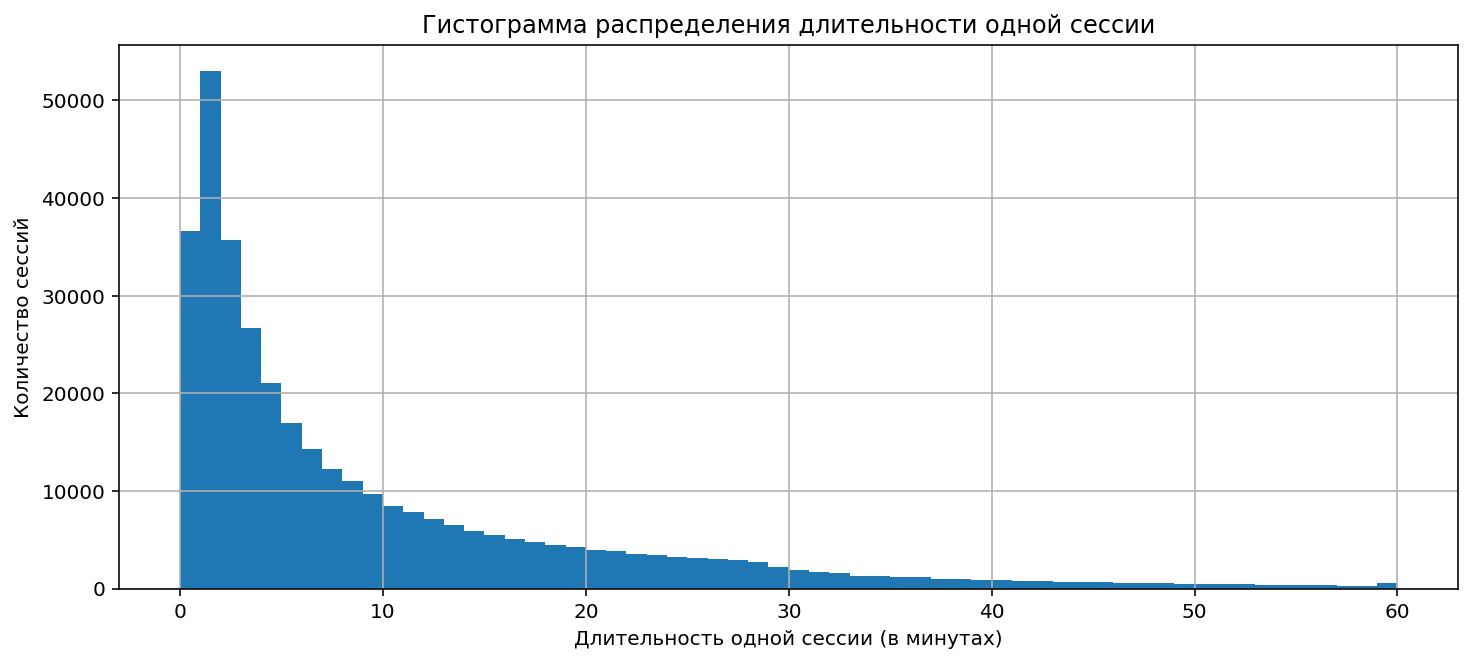

In [28]:
visits['visit_duration'].hist(bins=60, range=(0,60),figsize=(12, 5))
plt.title('Гистограмма распределения длительности одной сессии')
plt.xlabel('Длительность одной сессии (в минутах)')
plt.ylabel('Количество сессий')
plt.show()

In [29]:
display(visits['visit_duration'].describe())

count    359400.000000
mean         10.724343
std          16.939390
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max        1408.000000
Name: visit_duration, dtype: float64

Рассчитаем метрику средней продолжительности сессии ASL (average session length). Поскольку распределение длительности сессии далеко от нормального, то считать будем через моду (значение в выборке, которое встречается чаще всего).

In [30]:
asl = visits['visit_duration'].mode()
print('Cредняя продолжительность сессии (ASL): ',asl[0])

Cредняя продолжительность сессии (ASL):  1


В данном случае 1 минута означает по сути сессию длительностью от 1 до 2 минут. Кажется, что такого времени для выбора и покупки билетов мало, чтобы сделать заказ. По сути такой пользователь просматривает главную страницу и уходит. Но возможно среднестатистический пользователь просто четко знает, что он хочет купить.

#### Как часто возвращаются люди?


Для более подробного понимания рассчитаем коэффициент удержания (Retention Rate) который показывает, сколько пользователей из когорты относительно их изначального числа вернулось в последующие периоды.

In [31]:
# Сгруппируем данные таблицы visits: для каждого пользователя найдем дату его первого визита
first_visit = visits.groupby(['uid'])['start_ts'].min()
first_visit.name = 'first_visit_time'

# Объединим с полученные данные с основной таблицей (visits)
visits = visits.join(first_visit,on='uid')

# Добавление столбца с номером месяца первого визита
visits['first_visit_month'] = visits['first_visit_time'].astype('datetime64[M]')

# Рассчитаем lifetime
visits['lifetime'] = visits['month'] - visits['first_visit_month']
visits['lifetime'] = visits['lifetime'] / np.timedelta64(1,'M')
visits['lifetime'] = visits['lifetime'].round().astype('int')

# Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни»:
cohorts = visits.groupby(['first_visit_month','lifetime']).agg({'uid':'nunique'}).reset_index() 
visit_users_count = cohorts[cohorts['lifetime'] == 0][['first_visit_month','uid']]
visit_users_count = visit_users_count.rename(columns={'uid':'cohort_users'}) 
cohorts = cohorts.merge(visit_users_count,on='first_visit_month') 
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']
cohorts['first_visit_month'] = cohorts['first_visit_month'].dt.strftime('%Y-%m')

# Создание сводной таблицы с расчетом Retention Rate
retention_pivot = cohorts.pivot_table(index='first_visit_month', columns='lifetime', values='retention', aggfunc='sum')
display(retention_pivot)

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Для более наглядного представления построим Heatmap:

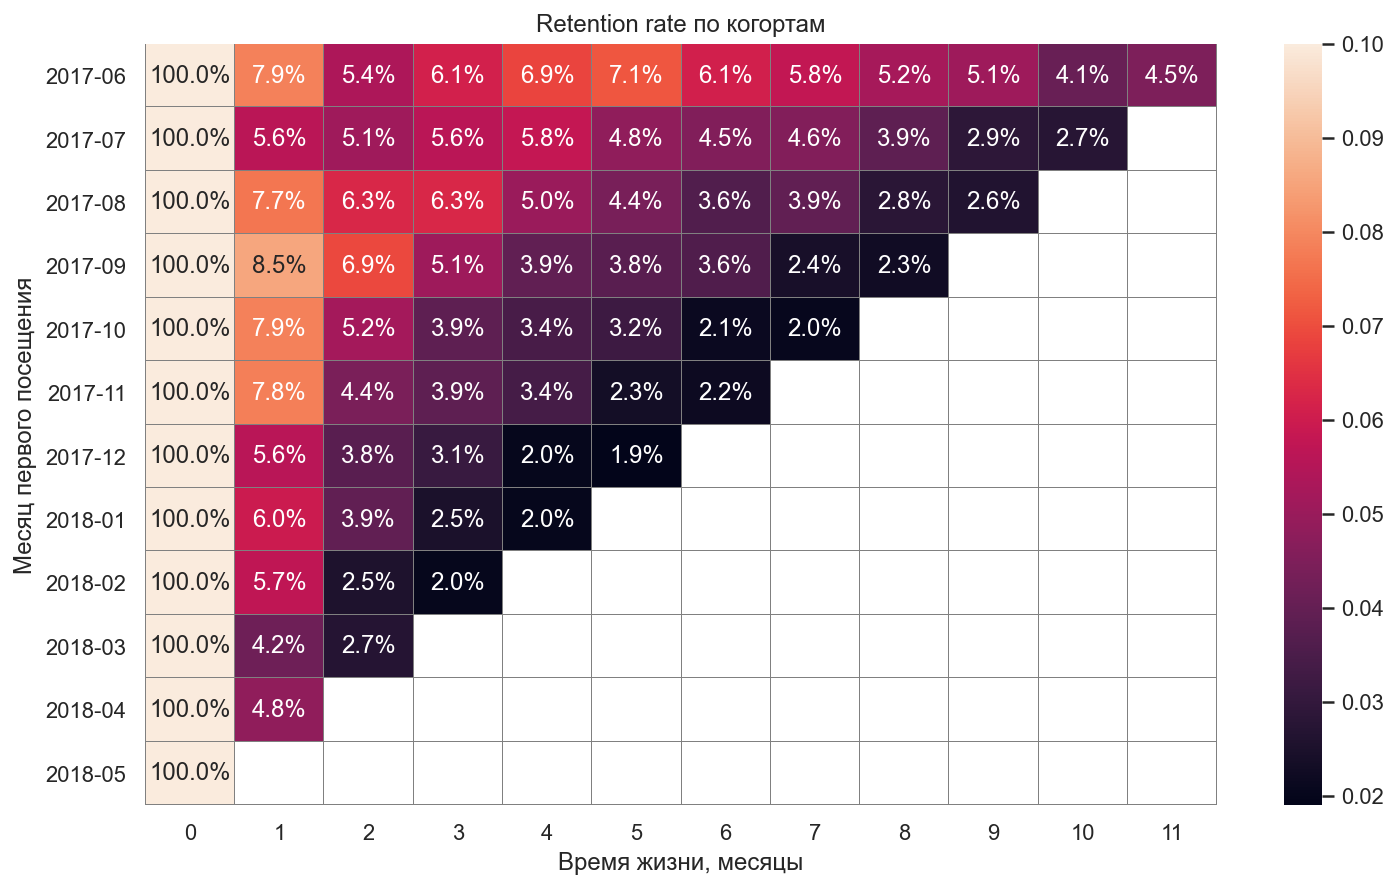

In [32]:
print_heatmap(retention_pivot, 'Retention rate по когортам', fmt='.1%', vmax=0.1, x_name='Время жизни, месяцы', y_name='Месяц первого посещения')

Возвращаются в сервис совсем небольшое количество пользователей: во второй месяц жизни остается не более 8.5%. Зато в последующие месяц падение значительно меньше, т.е. оставшиеся пользователи начинают стабильно пользоваться сервисом.

#### Выводы по пункту 2.1. Продукт
* Активность пользователей меняется в зависимости от дня недели
* Также на активность пользователей влияет сезон года: в весенне-летний период активность сильно снижается
* Доля устройств desktop занимает большую часть от всех сессий (73%)
* На одного пользователя приходится в среднем 1 сессия в день.
* Пользователи в основном приходят из источников 4, 3, 5, 2. Доля источников 6 и 7 практически нулевая
* Чаще всего продолжительность сессии составляет 2 минуты.
* В основном сервисом остается небольшое количество пользователей: retention rate во второй месяц составляет от 4 до 8% и в последующие месяц не превышает 7%

### 2.2. Продажи <a class="anchor" id="h2_2_2"></a>
Вопросы, на которые требуется ответить в данном пункте:
* Когда люди начинают покупать?
* Сколько раз покупают за период?
* Какой средний чек?
* Сколько денег приносят? (LTV)

#### Когда люди начинают покупать?
Для ответа на этот вопрос посчитаем для каждого пользователя время, которое проходит между первым посещением и первым заказом

count    36509.000000
mean       249.216522
std        429.770861
min          0.000000
25%          4.000000
50%         16.000000
75%        252.000000
max       1439.000000
Name: first_order, dtype: float64

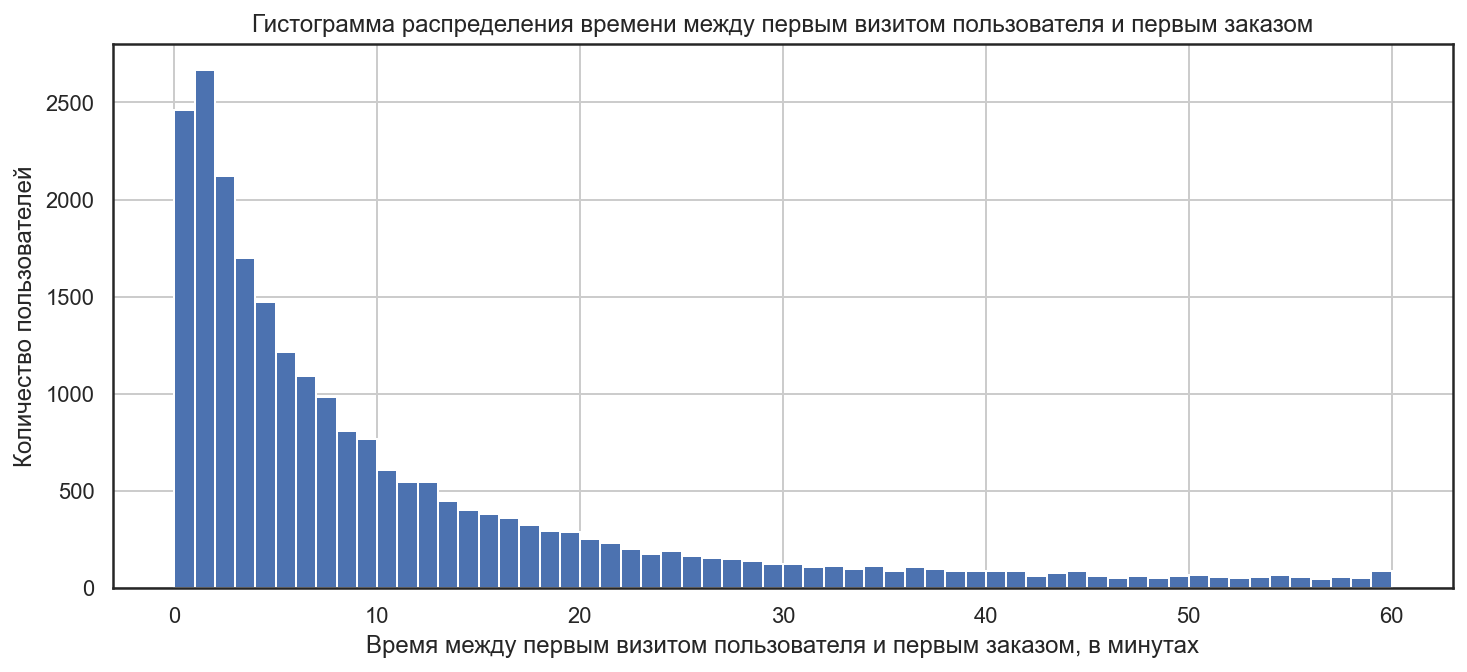

In [33]:
# Сгруппируем данные таблицы orders: для каждого пользователя найдем дату его первого заказа
orders_users = orders.groupby(['uid'])['buy_ts'].min()
orders_users.name = 'first_order_time'
orders_users = orders_users.to_frame()
# Объединим с полученные данные с основной таблицей (first_visit)
orders_users = orders_users.join(first_visit,on='uid')
orders_users['first_order'] = (orders_users['first_order_time'] - orders_users['first_visit_time']).dt.seconds / 60
# Вывод основных характеристик полученной колонки
display(orders_users['first_order'].describe())
# Построение гистограммы распределения
orders_users['first_order'].hist(bins=60, range=(0,60), figsize=(12,5))
plt.grid(True)
plt.title('Гистограмма распределения времени между первым визитом пользователя и первым заказом')
plt.xlabel('Время между первым визитом пользователя и первым заказом, в минутах')
plt.ylabel('Количество пользователей')
plt.show()

Полученные данные большинство пользователей делают заказ в течение первых 20 минут с момента начала свой первой сессии, т.е. с момента первого знакомства с сервисом. Причем значительна часть пользователей делает покупки в течение первых минут. Получается, что такие пользователи не выбирают билеты, они приходят четко понимая, чего хотят.

#### Сколько раз покупают за период?
Рассчитаем количество заказов за день, неделю и месяц.

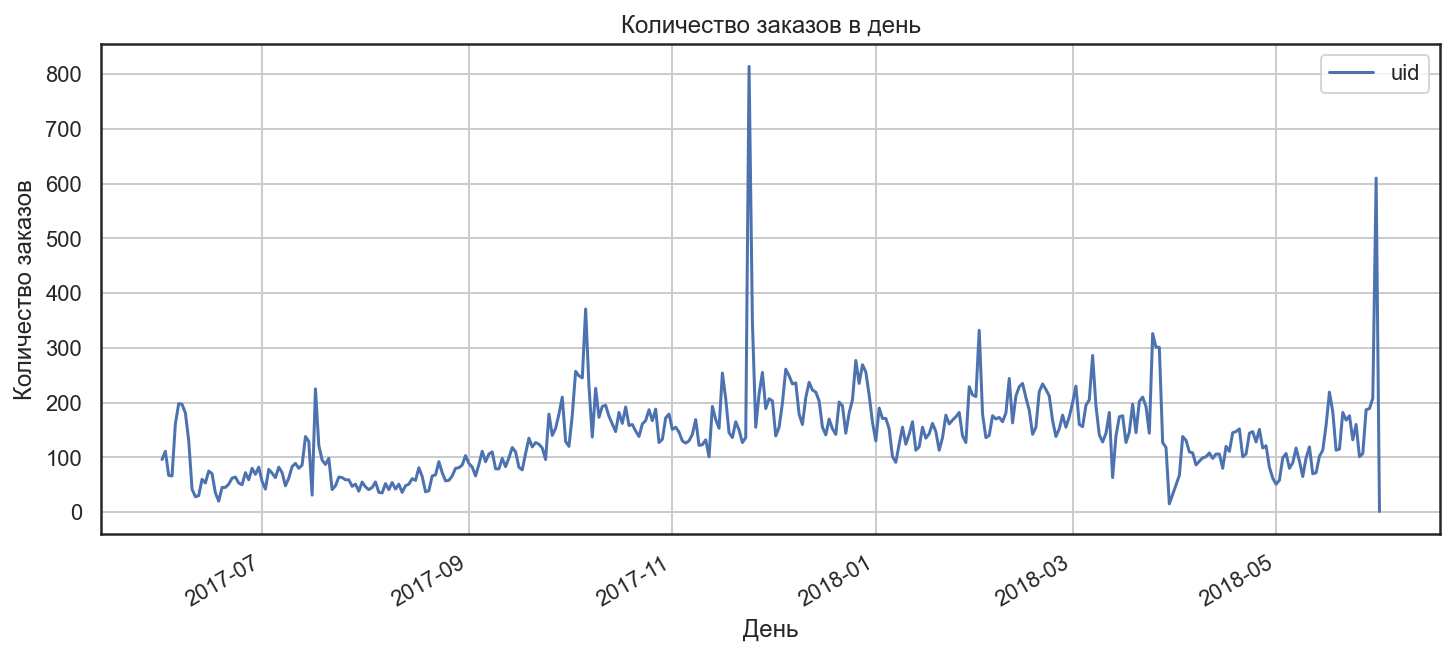

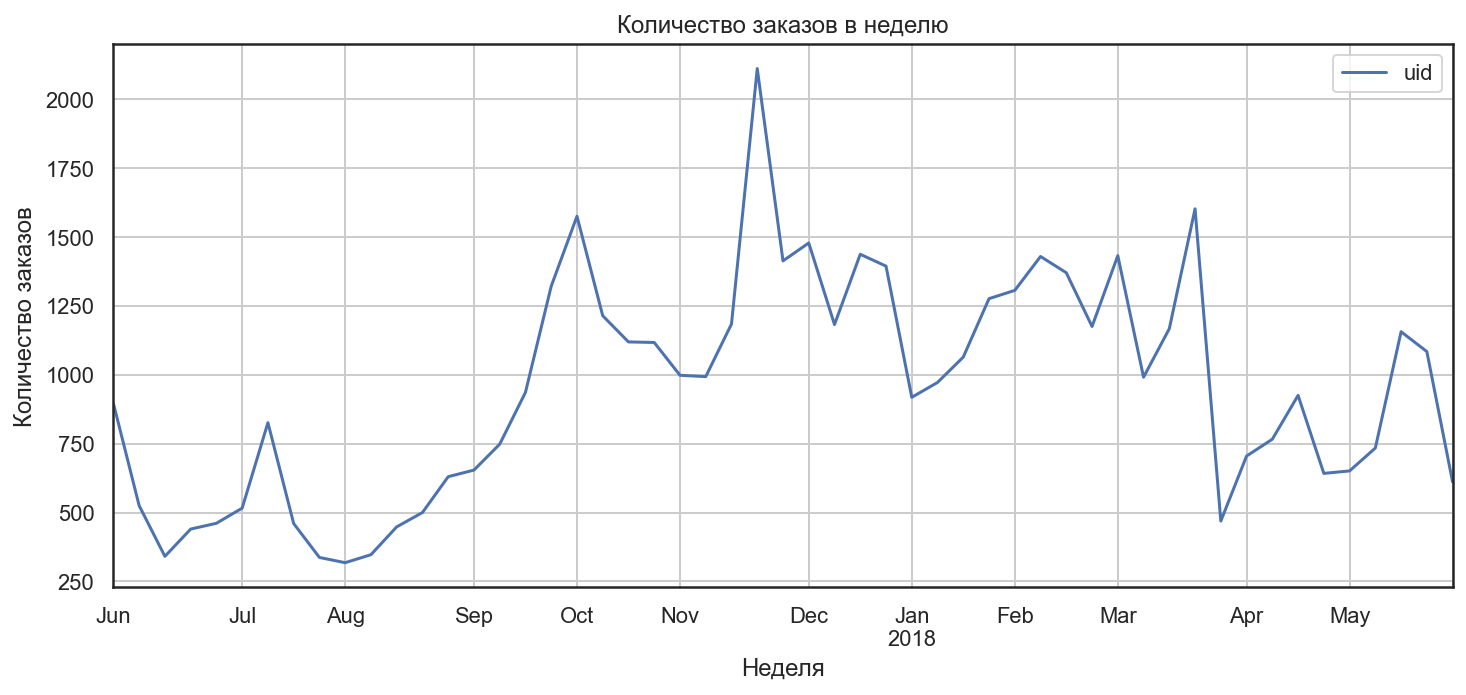

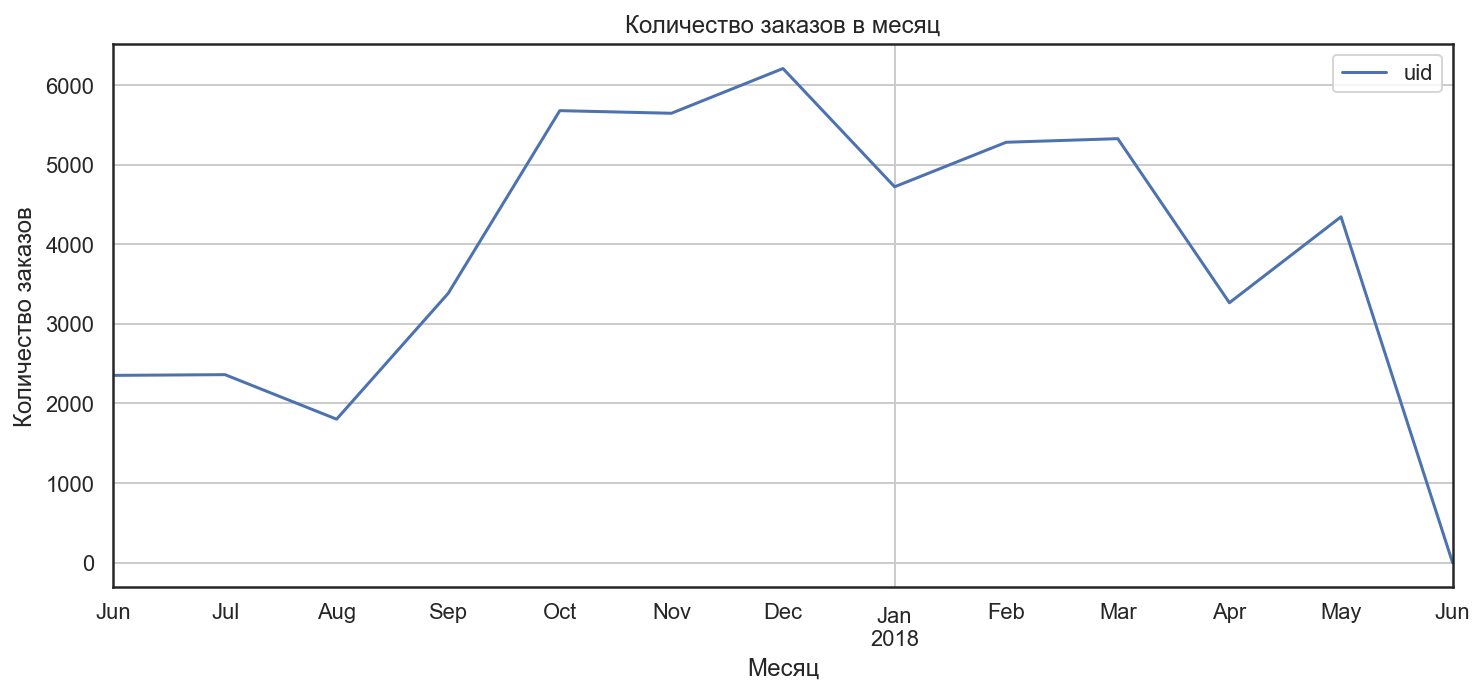

In [34]:
# Добавление колонок с датой, неделей и месяцем заказа
orders['order_date'] = orders['buy_ts'].astype('datetime64[D]')
orders['order_week'] = orders['buy_ts'].astype('datetime64[W]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

# Построение графиков
print_plot(orders.groupby('order_date')[['uid']].count(), 
           'line', 'Количество заказов в день', 'День', 'Количество заказов')

print_plot(orders.groupby('order_week')[['uid']].count(), 
           'line', 'Количество заказов в неделю', 'Неделя', 'Количество заказов')

print_plot(orders.groupby('order_month')[['uid']].count(), 
           'line', 'Количество заказов в месяц', 'Месяц', 'Количество заказов')

В целом картина на данных графиках схожа с картиной посещаемости. Здесь также видна сезонность покупок, зависимость от дня недели, локальные пики продаж и падения в те же периоды.

Рассчитаем среднее число покупок, приходящееся на одного клиента за определенный период времени, например, по месяцам и за полгода.

In [35]:
# Расчет среднего числа покупок по месяцам
orders_per_client = orders.groupby(['order_month']).agg({'uid': ['count','nunique']}).reset_index()
orders_per_client.columns = ['month','orders_count','users_count']
orders_per_client['avg_orders_per_user'] = orders_per_client['orders_count'] / orders_per_client['users_count']
print('Cреднее число покупок на одного клиента по месяцам:')
display(orders_per_client)

# Расчет среднего числа покупок по полугодиям
print('Cреднее число покупок на одного клиента по полугодиям:')
print('За 1-ое полугодие: {:.2f}'.format(orders[orders['order_month'] < pd.Timestamp(2017, 12, 1)].groupby('uid').agg({'uid': 'count'}).mean()['uid']))
print('За 2-ое полугодие: {:.2f}'.format(orders[orders['order_month'] >= pd.Timestamp(2017, 12, 1)].groupby('uid').agg({'uid': 'count'}).mean()['uid']))

# Расчет среднего числа покупок за весь рассматриваемый период (за год)
print('Cреднее число покупок на одного клиента за весь рассматриваемый период (за год): {:.2f}'.format(orders.groupby('uid').agg({'uid': 'count'}).mean()['uid']))

Cреднее число покупок на одного клиента по месяцам:


,month,orders_count,users_count,avg_orders_per_user
0,2017-06-01,2353,2022,1.163699
1,2017-07-01,2362,1983,1.191125
2,2017-08-01,1803,1471,1.225697
3,2017-09-01,3383,2748,1.231077
4,2017-10-01,5677,4673,1.214851
5,2017-11-01,5644,4543,1.242351
6,2017-12-01,6206,4937,1.257039
7,2018-01-01,4721,3898,1.211134
8,2018-02-01,5280,4258,1.240019
9,2018-03-01,5325,4181,1.273619


Cреднее число покупок на одного клиента по полугодиям:
За 1-ое полугодие: 1.30
За 2-ое полугодие: 1.34
Cреднее число покупок на одного клиента за весь рассматриваемый период (за год): 1.38


Значения среднего количества покупок за все время, по полугодиям и по месяцам несильно отличаются друг от друга. По полученным данным видно, что редко когда клиент совершает вторую покупку.

#### Какой средний чек?

Рассчитаем средний чек в динамике и построим графики:

Средний чек за день:  5.334269881866317
Средний чек за неделю:  5.779353020253249
Средний чек за месяц:  5.86939593815615


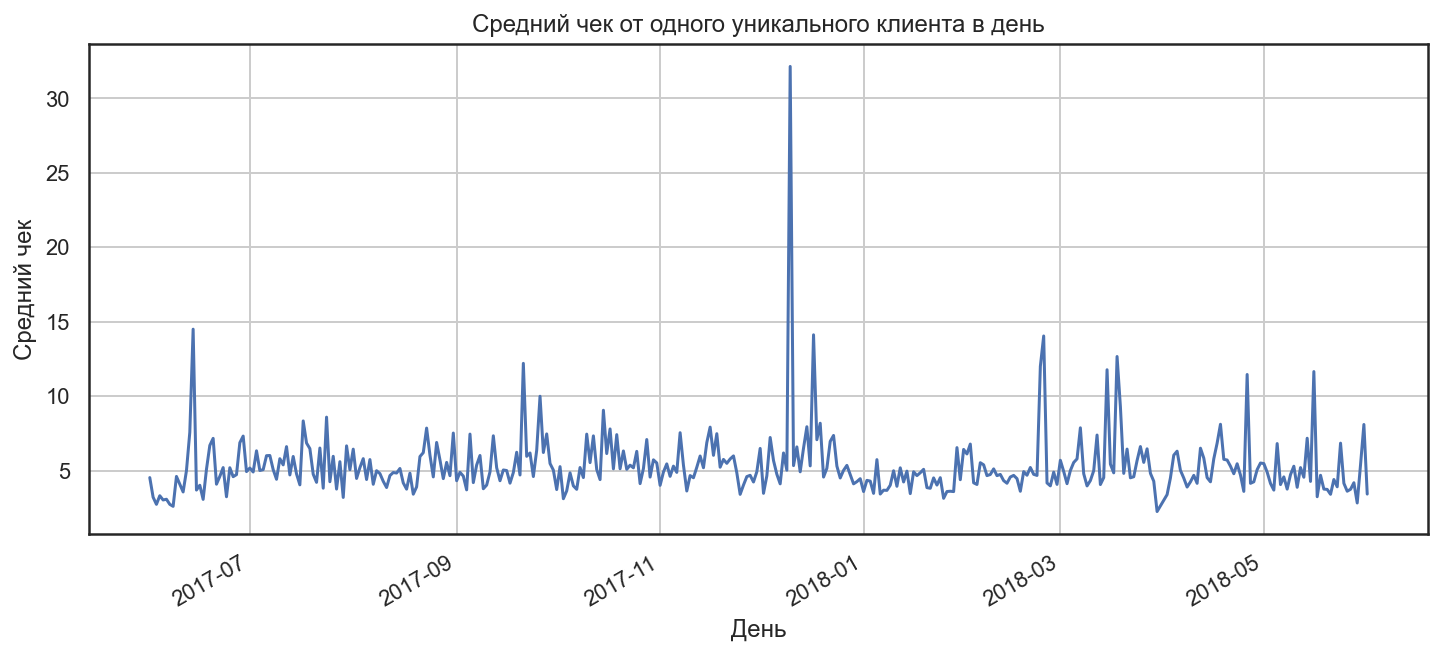

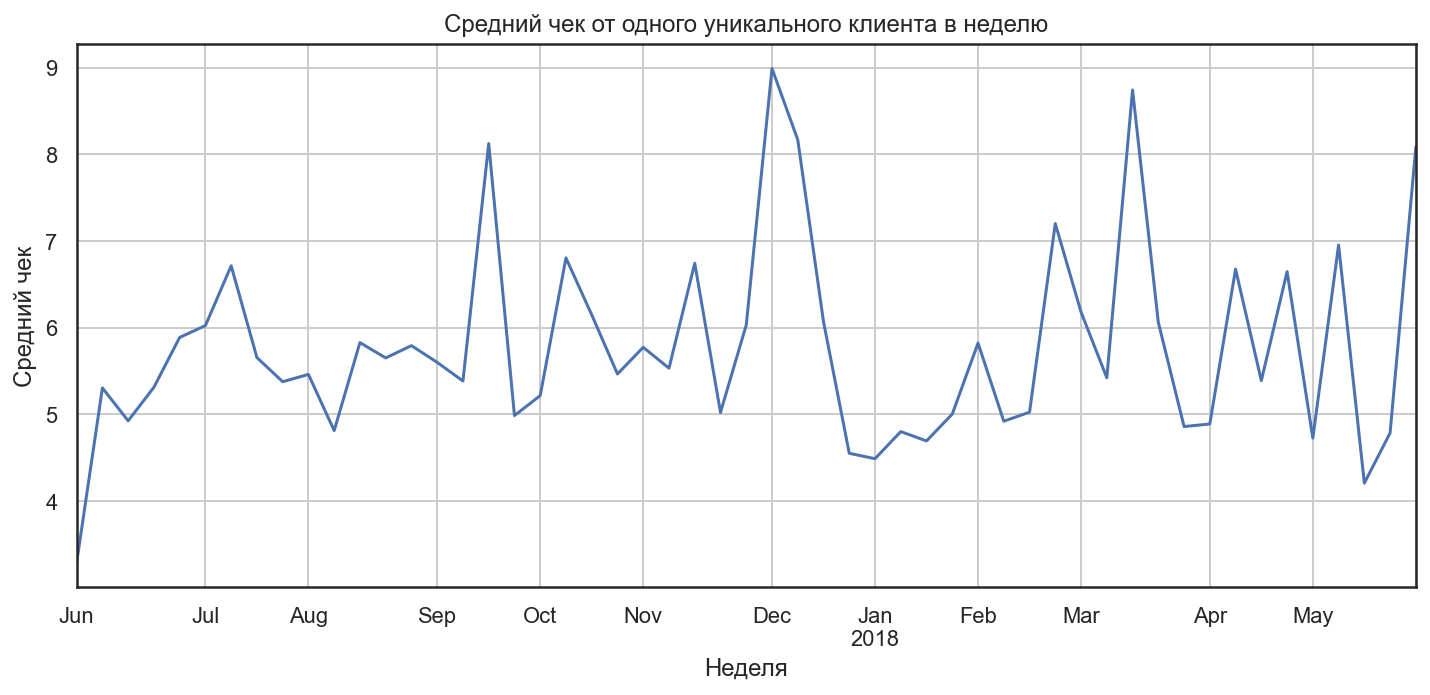

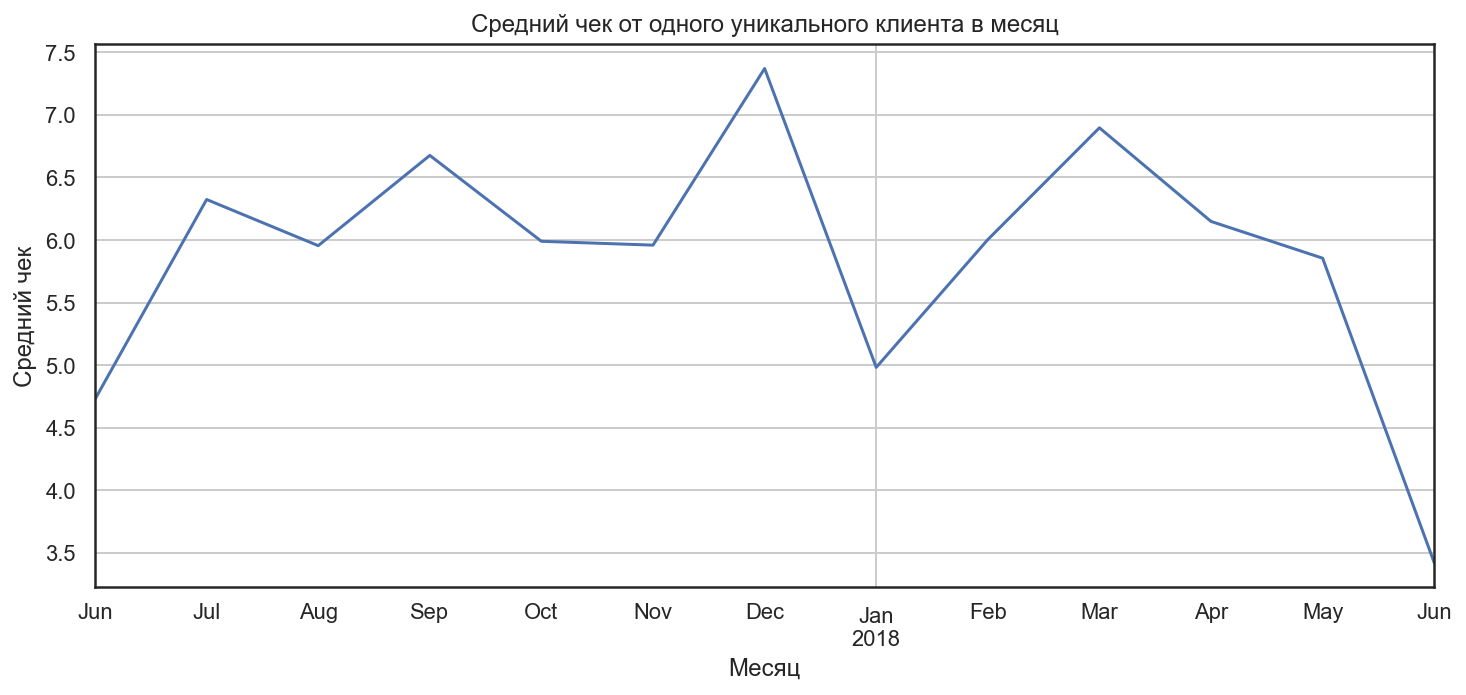

In [36]:
# Расчет среднего чека за день
avg_revenue_date = orders.groupby('order_date').agg({'uid':'nunique','revenue':'sum'})
avg_revenue_date.columns = ['n_orders','total_revenue']
avg_revenue_date['avg_revenue'] = avg_revenue_date['total_revenue'] / avg_revenue_date['n_orders']
print('Средний чек за день: ',avg_revenue_date['avg_revenue'].mean())

# Расчет среднего чека за неделю
avg_revenue_week = orders.groupby('order_week').agg({'uid':'nunique','revenue':'sum'})
avg_revenue_week.columns = ['n_orders','total_revenue']
avg_revenue_week['avg_revenue'] = avg_revenue_week['total_revenue'] / avg_revenue_week['n_orders']
print('Средний чек за неделю: ',avg_revenue_week['avg_revenue'].mean())

# Расчет среднего чека за месяц
avg_revenue_month = orders.groupby('order_month').agg({'uid':'nunique','revenue':'sum'})
avg_revenue_month.columns = ['n_orders','total_revenue']
avg_revenue_month['avg_revenue'] = avg_revenue_month['total_revenue'] / avg_revenue_month['n_orders']
print('Средний чек за месяц: ',avg_revenue_month['avg_revenue'].mean())

# Построение графиков
print_plot(avg_revenue_date['avg_revenue'], 'line', 'Средний чек от одного уникального клиента в день', 'День', 'Средний чек')
print_plot(avg_revenue_week['avg_revenue'], 'line', 'Средний чек от одного уникального клиента в неделю', 'Неделя', 'Средний чек')
print_plot(avg_revenue_month['avg_revenue'],'line', 'Средний чек от одного уникального клиента в месяц', 'Месяц', 'Средний чек')

* Значение среднего чека по разным периодам отличается незначительно. Это говорит о том, что клиенты редко делают больше одной покупки в месяц
* Значение среднего чека оказалось достаточно стабильным на протяжении всего года, т.е. в данном случае не прослеживается сезонность, как в посещениях и заказах
* На всех трех графиках заметно увеличение среднего чека в декабре и его снижение в январе. Видимо это связано с новогодними праздниками, накануне которых люди более склонны делать дорогие покупки. А после праздников, когда много денег потрачено, склонны экономить.

 #### Сколько денег приносят? (LTV)
Посчитаем показатель LTV (Lifetime Value) - итоговую сумму денег, которую клиенты приносят в среднем со всех своих покупок.

Для оценки результативности когорт возьмем только те когорты, время жизни (lifetime) которых составляет не менее 6 месяцев.

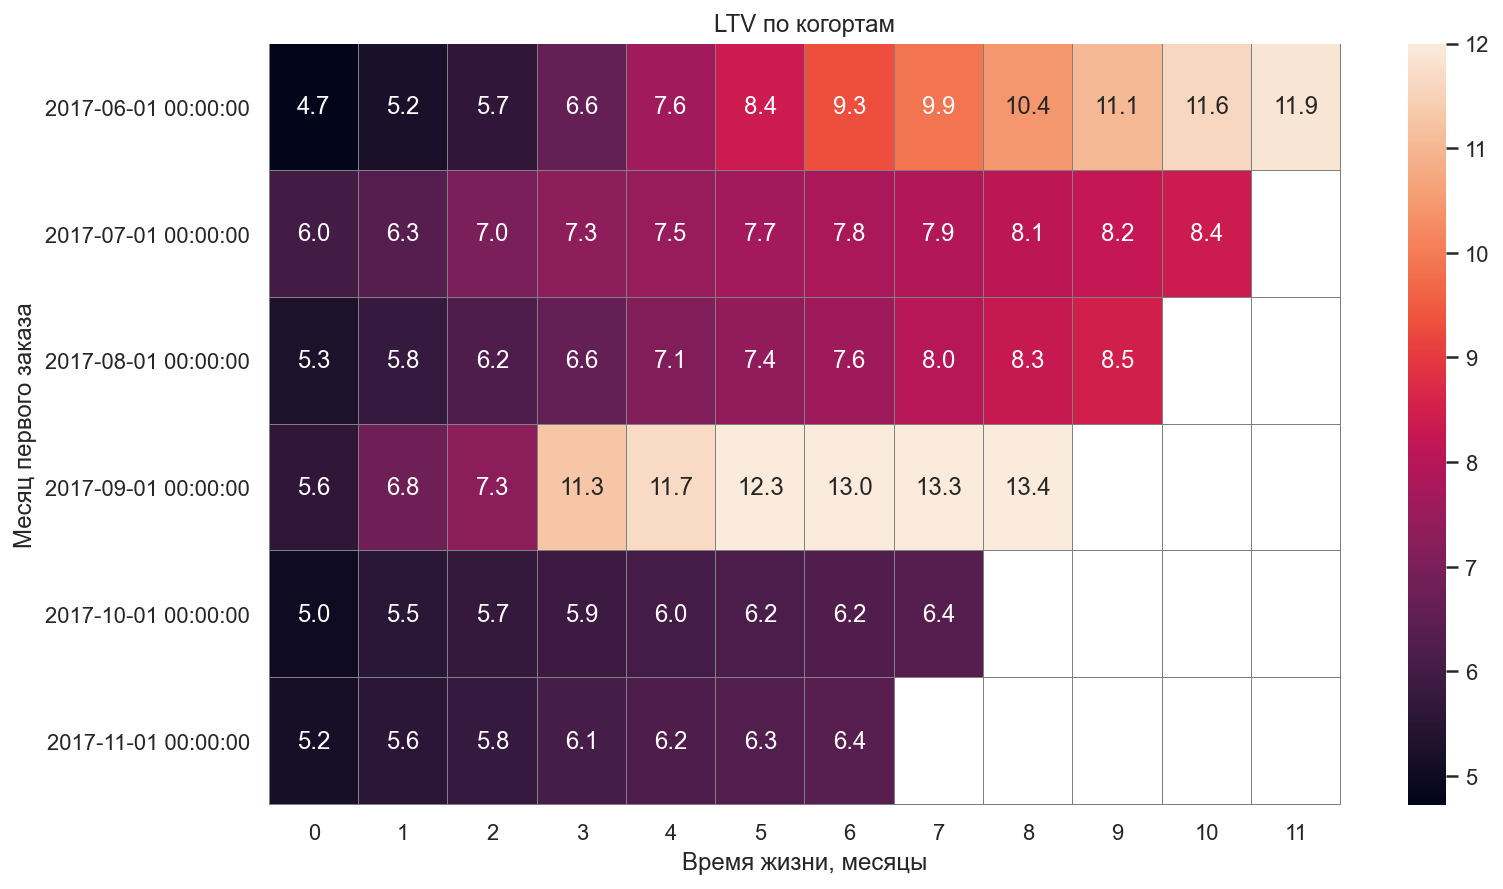

In [37]:
# Cоздание колонки first_month с месяцем первого заказа
orders = orders.join(orders.groupby('uid').agg(first_month=('buy_ts', 'min')).astype('datetime64[M]'), on='uid')
 
# Cоздание когорт
ltv_cohorts = orders.groupby(['first_month', 'order_month']).agg({'revenue': 'sum', 'uid': 'nunique'}).reset_index()
ltv_cohorts['cohort_lifetime'] = ((ltv_cohorts['order_month'] - ltv_cohorts['first_month']) / np.timedelta64(1, 'M')).round().astype('int')
ltv_cohorts = ltv_cohorts.join(ltv_cohorts.query('cohort_lifetime == 0').groupby('first_month').agg(cohort_size=('uid', 'sum')), on='first_month')

# Расчет LTV, приняв маржинальность = 1, т.е. LTV = отношение валовой прибыли за месяц к размеру соответствующей когорты 
ltv_cohorts['ltv'] = ltv_cohorts['revenue'] / ltv_cohorts['cohort_size']

# Построение сводной таблицы и расчет LTV
ltv_pivot = ltv_cohorts.pivot_table(index='first_month', columns='cohort_lifetime', values='ltv').cumsum(axis=1)

# Удаление из сводной таблицы когорт, время жизни которых меньше 6 месяцев
ltv_pivot = ltv_pivot[ltv_pivot[6].notna()]

# Построение тепловой карты по рассчитанному LTV
print_heatmap(ltv_pivot, 'LTV по когортам', fmt='0.1f', vmax=12, x_name='Время жизни, месяцы', y_name='Месяц первого заказа')

* Наибольший LTV показывает когорта сентября 2017 года: за первые полгода клиенты сделали заказов столько же, сколько и клиенты самой старшей когорты (июнь 2017 года) за год.
* На втором месте по результативности - когорта июня 2017 года. Причем LTV в течение всего времени жизни стабильно растет.


Рассчитаем накопительный LTV за 6 месяцев после первой покупки, что даст понимание, сколько в среднем приносят клиенты, которые условно являются "постоянными".

In [38]:
# Рассчитаем накопительный LTV за 6 месяцев после первой покупки
m6_cum_ltv = ltv_pivot.mean(axis=0) [5] 

print('Средний LTV за 6 месяцев после первой покупки: {:.1f}'.format(m6_cum_ltv))

Средний LTV за 6 месяцев после первой покупки: 8.0


Таким образом, маркетологи могут тратить на привлечение одного покупателя не более 8 у.е., если хотят, чтобы реклама окупилась за 6 месяцев.

Теперь рассчитаем LTV в разрезе источников.

Для этого в таблице заказов необходимы данные об источнике, откуда клиент был первоначально привлечен (считаем, что мы один раз привлекли пользователя, а для повторных покупок он приходит сам).

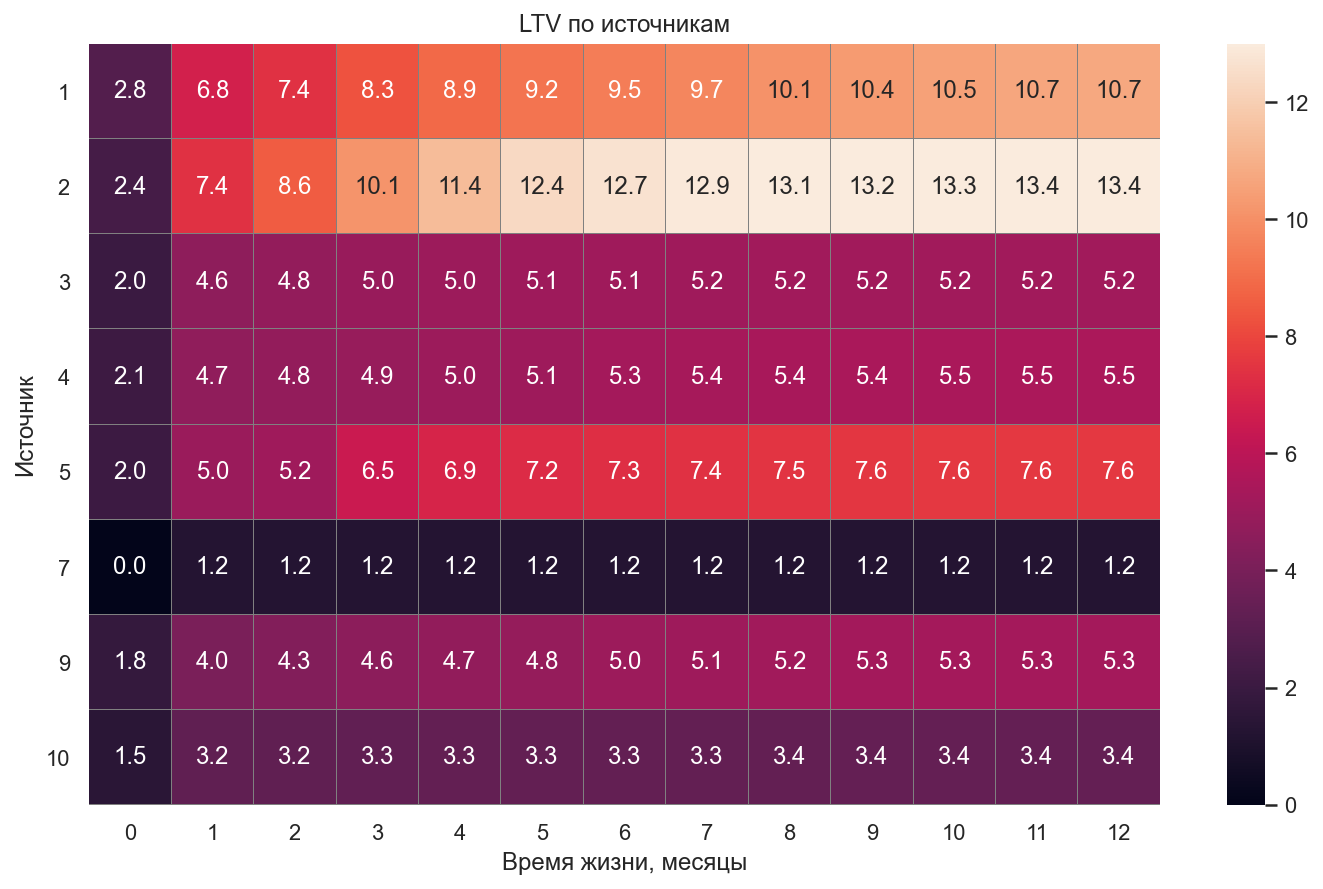

In [39]:
# Сначала найдем для каждого пользователя источник, от которого он попал первый раз
first_visits_sources = visits.sort_values(by='start_ts').groupby('uid').agg({'source_id': 'first'}).reset_index()

# Добавим этот источник в таблицу с заказами
orders = orders.merge(first_visits_sources, on = 'uid')

# Добавление колонки с временем жизни
orders['lifetime'] = ((orders['buy_ts'] - orders['first_month']) / np.timedelta64(1, 'M')).round().astype(int)

# Создание сводной таблицы для расчета LTV по источникам
ltv_sources = orders.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue', aggfunc = 'sum').fillna(0)

# Расчет выручки
ltv_sources = ltv_sources.cumsum(axis = 1)

# Расчет размера когорт по каждому источнику
cohort_sizes = orders.groupby('source_id').agg({'uid': 'nunique'}).rename(columns = {'uid': 'cohort_size'})
ltv_sources = ltv_sources.merge(cohort_sizes, on = 'source_id')

# Деление выручки на размер когорт
ltv_sources = ltv_sources.div(ltv_sources['cohort_size'], axis = 0).drop(columns = 'cohort_size')

# Построение тепловой карты по рассчитанному LTV
print_heatmap(ltv_sources, 'LTV по источникам', fmt='0.1f', vmax=13, x_name='Время жизни, месяцы', y_name='Источник')

* В разрезе источников наибольшую LTV дают клиенты, привлеченные из источников 2, 1, 5.
* Хуже всего показывает источник 7 в виду того, что заказов по нему практически не было.
* Источник 6 отсутствует совсем

#### Выводы по пункту 2.2. Продажи
* Значительная часть пользователей делает покупки в течение первых минут. При этом большинство пользователей делают заказ в течение первых 20 минут с момента начала свой первой сессии, т.е. с момента первого знакомства с сервисом.
* В продажах также видна сезонность покупок, зависимость от дня недели, локальные пики продаж и падения в те же периоды, что и в посещаемости.
* Средний чек равен примерно 5. Значение среднего чека оказалось достаточно стабильным на протяжении всех периодов. Заметно увеличение среднего чека в декабре и его снижение в январе. Видимо это связано с новогодними праздниками, накануне которых люди более склонны делать дорогие покупки. А после праздников, когда много денег потрачено, склонны экономить.
* Наибольший LTV показывает когорта сентября 2017 года: за первые полгода клиенты сделали заказов столько же, сколько и клиенты самой старшей когорты за год
* В разрезе источников наибольшую LTV дают клиенты, привлеченные из источников 2, 1, 5. Хуже всего показывает источник 7 в виду того, что заказов по нему практически не было.
* Маркетологи могут тратить на привлечение одного покупателя не более 8 у.е., если хотят, чтобы реклама окупилась за 6 месяцев.

### 2.3. Маркетинг <a class="anchor" id="h2_2_3"></a>
Вопросы, на которые требуется ответить в данном пункте:
* Сколько денег потратили? (всего / на каждый источник / по времени)
* Сколько стоило привлечение одного покупателя из каждого источника?
* На сколько окупились расходы? (ROI)

#### Сколько денег потратили? (всего / на каждый источник / по времени)
Посчитаем сначала, сколько было всего потрачено на привлечение клиентов и сравним с оборотом - общей суммой денег, которую клиенты заплатили компании.

In [40]:
print('Всего потрачено: ', costs['costs'].sum())
print('Суммарная выручка (оборот): ', orders['revenue'].sum())

Всего потрачено:  329131.62
Суммарная выручка (оборот):  252057.2


Всего на маркетинг потрачено значительно больше, чем было выручено.

Посчитаем затраты и выручку в разрезе источников:

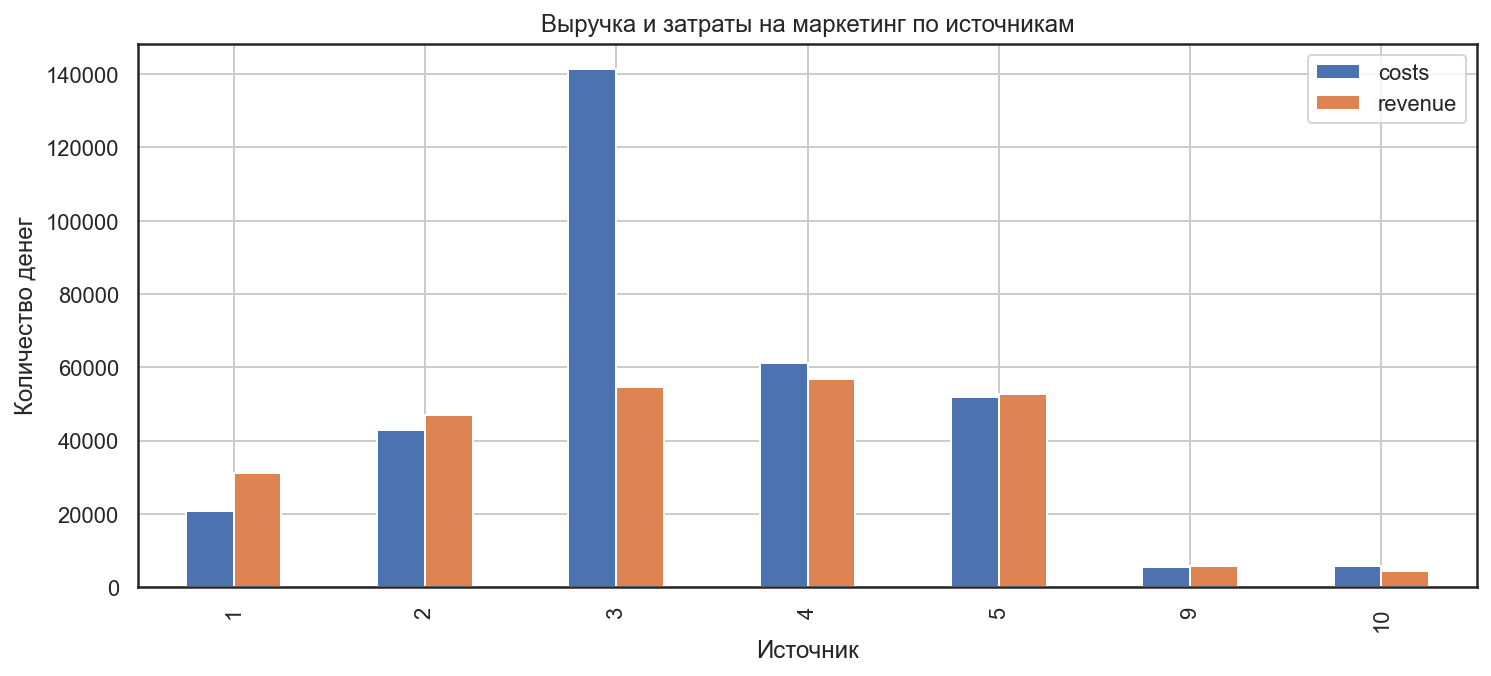

In [41]:
# Расчет суммы потраченных средств по каждому источнику
sources_costs = costs.groupby('source_id').sum()
# Расчет суммы вырученных средств по каждому источнику
sources_orders = orders.groupby('source_id')['revenue'].agg(['sum'])
sources_orders.columns = ['revenue']
# Объедиение данных по затратам и выручке
sources_stat = sources_costs.merge(sources_orders, on='source_id')
# Построение диаграммы
print_plot(sources_stat, 'bar', 'Выручка и затраты на маркетинг по источникам', 'Источник', 'Количество денег')

* Больше всего денег потрачено на источник 3, далее идут источники 4, 5. Источник 2 и 1, которые дают наибольшую LTV, оказались только на четвертом и пятом местах по расходам на маркетинг.
* На источник 3 потрачено намного больше, чем выручено. В остальных случаях выручка находится на уровне с затратами.

Далее рассчитаем затраты по времени (по каждому дню, неделю и месяцу).

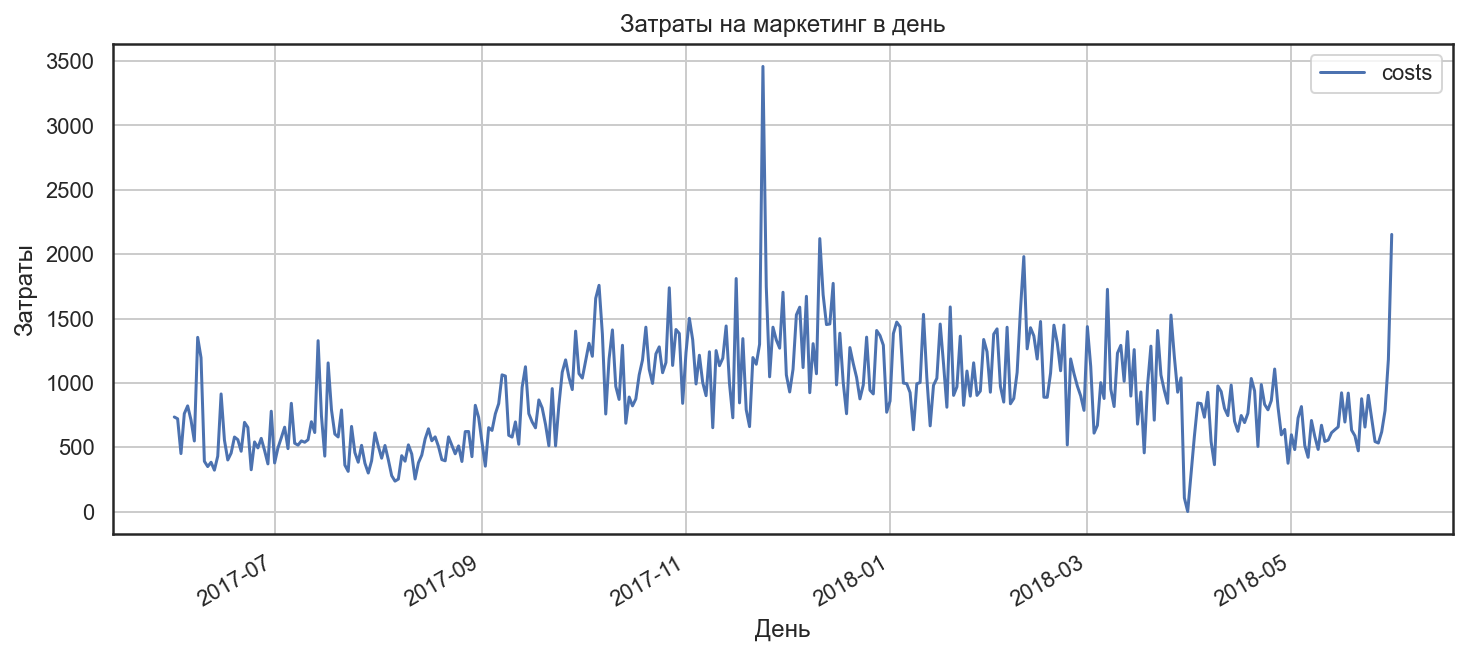

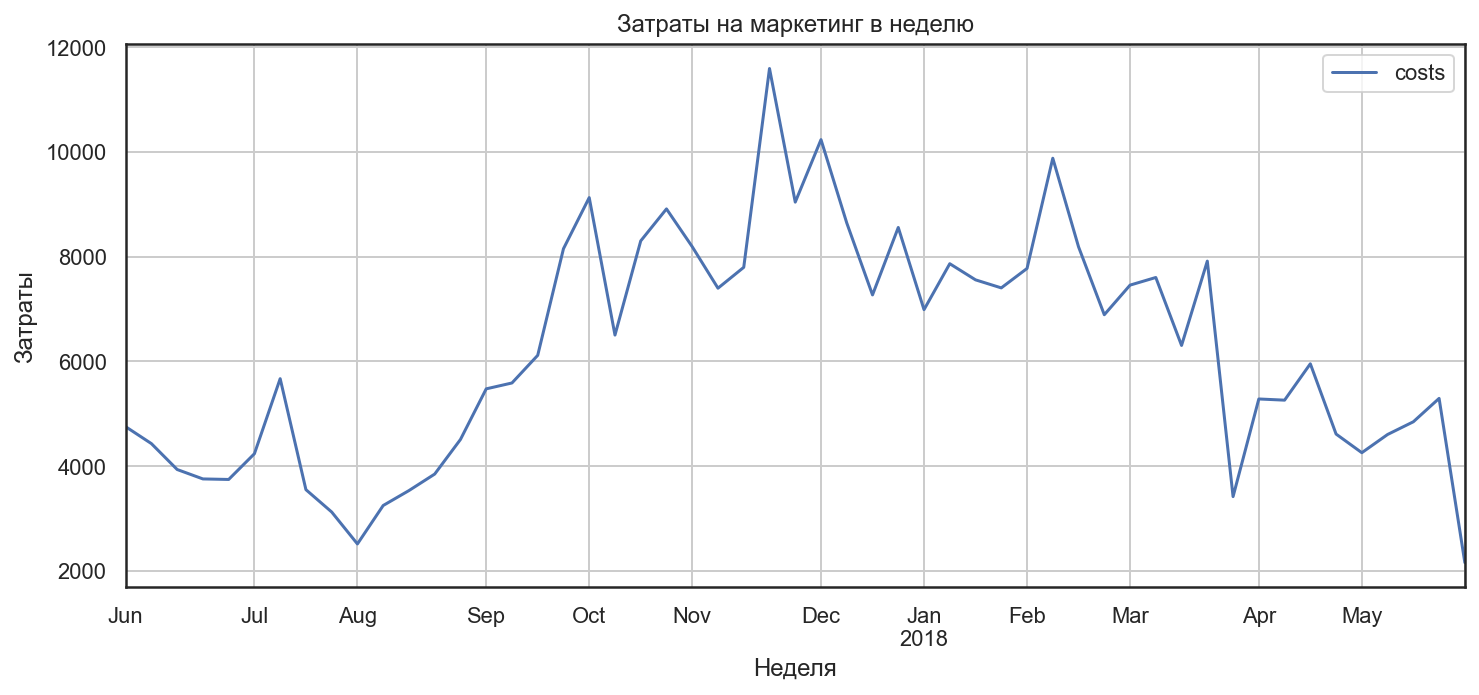

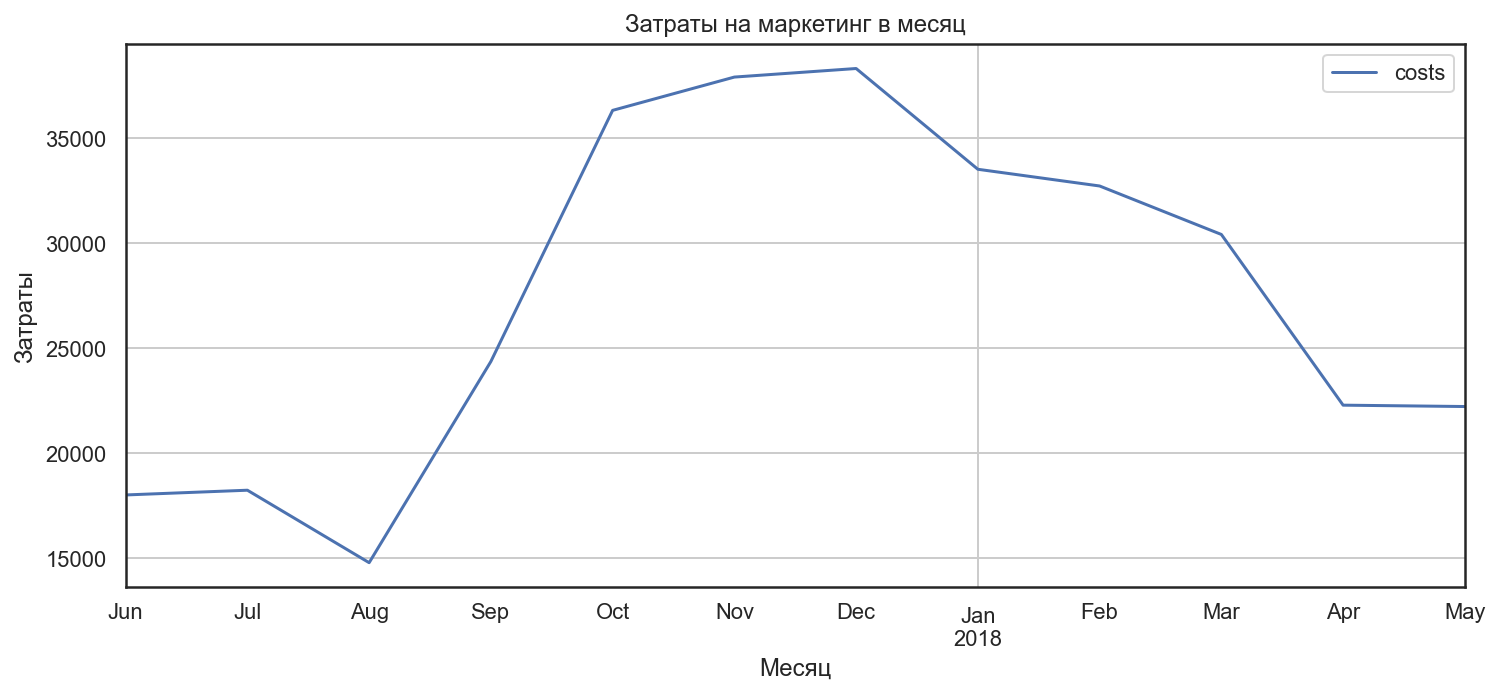

In [42]:
# Добавление колонок с датой, неделей и месяцем
costs['date'] = costs['dt'].astype('datetime64[D]')
costs['week'] = costs['dt'].astype('datetime64[W]')
costs['month'] = costs['dt'].astype('datetime64[M]')

# Расчет и построение графиков
print_plot(costs.groupby('date')[['costs']].sum(), 
           'line', 'Затраты на маркетинг в день', 'День', 'Затраты')

print_plot(costs.groupby('week')[['costs']].sum(), 
           'line', 'Затраты на маркетинг в неделю', 'Неделя', 'Затраты')

print_plot(costs.groupby('month')[['costs']].sum(), 
           'line', 'Затраты на маркетинг в месяц', 'Месяц', 'Затраты')

Затраты на маркетинг очень схожи с картиной посещаемости и заказов. Для проверки рассчитаем коэффициенты корреляции между размером трат на маркетинг и посещяемостью, а также с количеством сделанных заказов.

In [43]:
costs_stat = costs.groupby('date')[['costs']].sum()
visits_stat = visits.groupby('date')[['uid']].nunique()
orders_stat = orders.groupby('order_date')[['uid']].count()
print('Корреляция затрат на маркетинг и количества посещений уникальных пользователей (за день): ',costs_stat['costs'].corr(visits_stat['uid']))
print('Корреляция затрат на маркетинг и количества заказов (за день): ',costs_stat['costs'].corr(orders_stat['uid']))

costs_stat = costs.groupby('week')[['costs']].sum()
visits_stat = visits.groupby('week')[['uid']].nunique()
orders_stat = orders.groupby('order_week')[['uid']].count()
print('Корреляция затрат на маркетинг и количества посещений уникальных пользователей (за неделю): ',costs_stat['costs'].corr(visits_stat['uid']))
print('Корреляция затрат на маркетинг и количества заказов (за неделю)',costs_stat['costs'].corr(orders_stat['uid']))

costs_stat = costs.groupby('month')[['costs']].sum()
visits_stat = visits.groupby('month')[['uid']].nunique()
orders_stat = orders.groupby('order_month')[['uid']].count()
print('Корреляция затрат на маркетинг и количества посещений уникальных пользователей (за месяц): ',costs_stat['costs'].corr(visits_stat['uid']))
print('Корреляция затрат на маркетинг и количества заказов (за месяц)',costs_stat['costs'].corr(orders_stat['uid']))

Корреляция затрат на маркетинг и количества посещений уникальных пользователей (за день):  0.8579980049881305
Корреляция затрат на маркетинг и количества заказов (за день):  0.7896519794177401
Корреляция затрат на маркетинг и количества посещений уникальных пользователей (за неделю):  0.9612532396334567
Корреляция затрат на маркетинг и количества заказов (за неделю) 0.9036289210622709
Корреляция затрат на маркетинг и количества посещений уникальных пользователей (за месяц):  0.9815898393933337
Корреляция затрат на маркетинг и количества заказов (за месяц) 0.9559150306520288


Расчет коэффициентов корреляции показывает, что количество новых пользователй и количество сделанных заказов сильно зависит от затрат на маркетинг даже в сравнении по дням.

#### Сколько стоило привлечение одного покупателя из каждого источника?
Рассчитаем CAC (customer acquisition cost) — стоимость привлечения клиента - сумма денег, во сколько обходится новый клиент компании.

Среднее значение CAC: 9.0


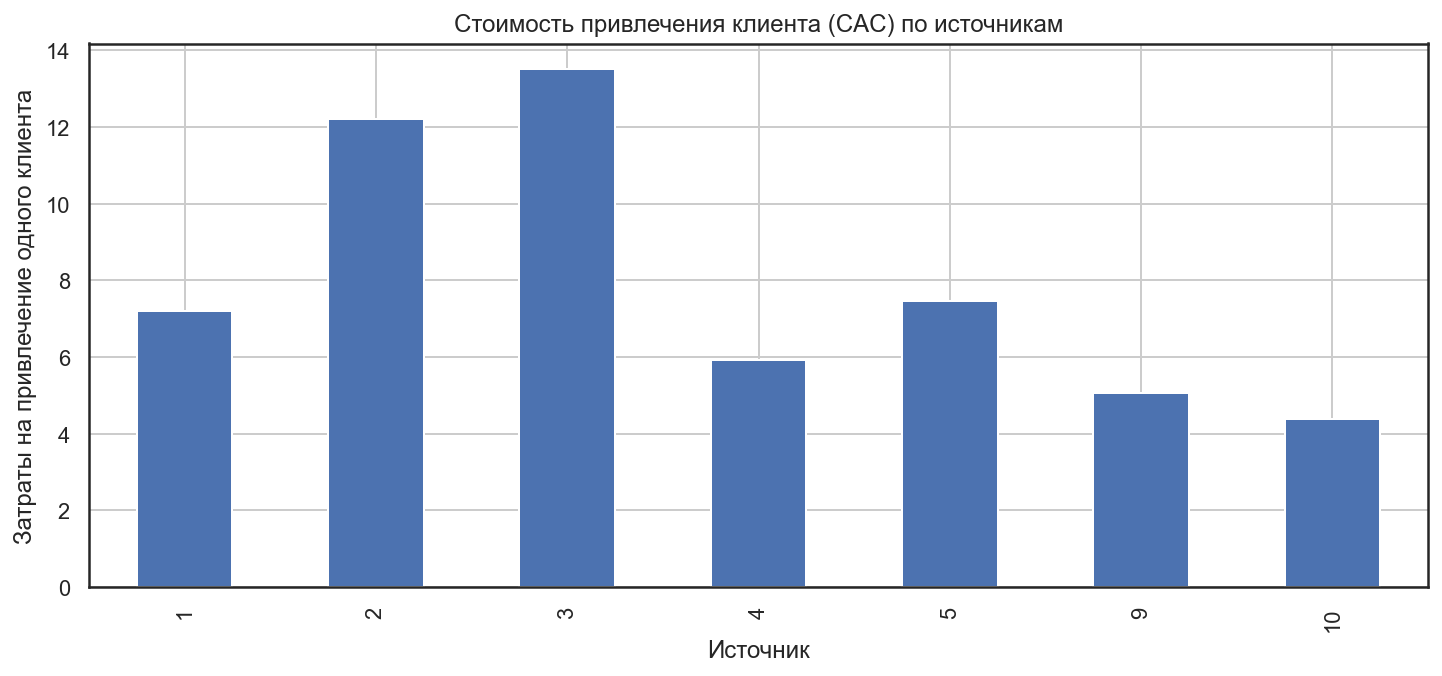

In [44]:
# Подсчет затрат на маркетинг по источникам и объединение полученных данных с данными по количеству клиентов, сделавших заказ
cac = costs.groupby('source_id').agg({'costs': 'sum'}).reset_index().merge(cohort_sizes.reset_index(), left_on = 'source_id', right_on='source_id')
# Расчет CAC
cac['cac'] = cac['costs'] / cac['cohort_size']
cac = cac.set_index('source_id')
print('Среднее значение CAC: {:.1f}'.format( cac['costs'].sum() / cac['cohort_size'].sum()))


print_plot(cac['cac'], 
           'bar', 'Стоимость привлечения клиента (CAC) по источникам', 'Источник', 'Затраты на привлечение одного клиента')

Наибольшая стоимость привлечения клиента - у источников 3 и 2.

#### На сколько окупились расходы? (ROI)

Зная LTV и CAC можно рассчитать значение ROMI - (Return On Marketing Investment) — показатель возврата инвестиций маркетинговых каналов.

In [45]:
# Объедиение таблицы с расчетом LTV и CAC
romi = ltv_sources.merge(cac[['cac']], on = 'source_id')

# Расчет ROMI: деление LTV на значение CAC по соответствующим источникам, а затем удаление столбца со значением CAC
romi = romi.div(romi['cac'], axis = 0).drop(columns = 'cac')

display(romi)

,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,0.390482,0.940153,1.030480,1.156697,1.239959,1.280921,1.314648,1.351542,1.404373,1.439180,1.463960,1.483118,1.492351
2,0.193883,0.603077,0.701574,0.828717,0.933581,1.013970,1.038325,1.058480,1.074018,1.081914,1.086308,1.095505,1.096191
3,0.148044,0.343022,0.356177,0.367044,0.373189,0.378101,0.380483,0.382342,0.384098,0.384836,0.385432,0.385595,0.385725
4,0.355915,0.789860,0.806871,0.825442,0.849530,0.859459,0.895625,0.904927,0.910567,0.917923,0.919322,0.927846,0.928336
5,0.272347,0.670657,0.691451,0.867653,0.928258,0.962136,0.977922,0.992758,1.000540,1.012327,1.015015,1.016546,1.016750
9,0.354598,0.795648,0.846974,0.903684,0.933894,0.955859,0.993497,1.007690,1.021725,1.040654,1.042316,1.043844,1.043844
10,0.334974,0.729360,0.740292,0.745722,0.755381,0.757621,0.758461,0.761313,0.763611,0.764020,0.764335,0.764335,0.764335


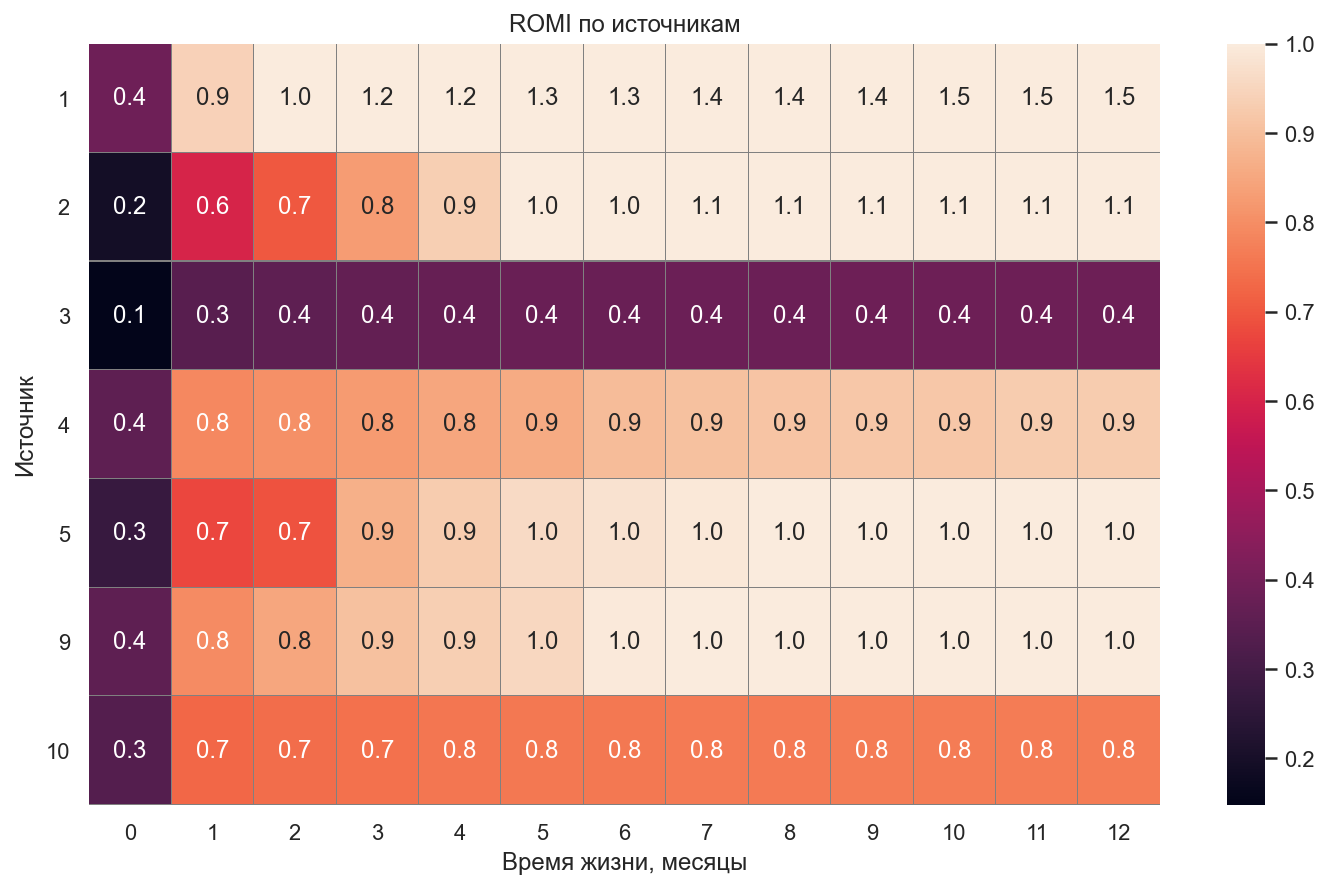

In [46]:
print_heatmap(romi, 'ROMI по источникам', fmt='0.1f', vmax=1, x_name='Время жизни, месяцы', y_name='Источник')

Быстрее всего окупилась когорта из источника 1: через 2 месяца. Позже окупаются когорты 2, 9, 5. Когорты из источников 3, 5, 10 не окупились вовсе за рассматриваемое время жизни. Хуже всего показала себя когорта из источника 3: она не окупилась даже на половину.

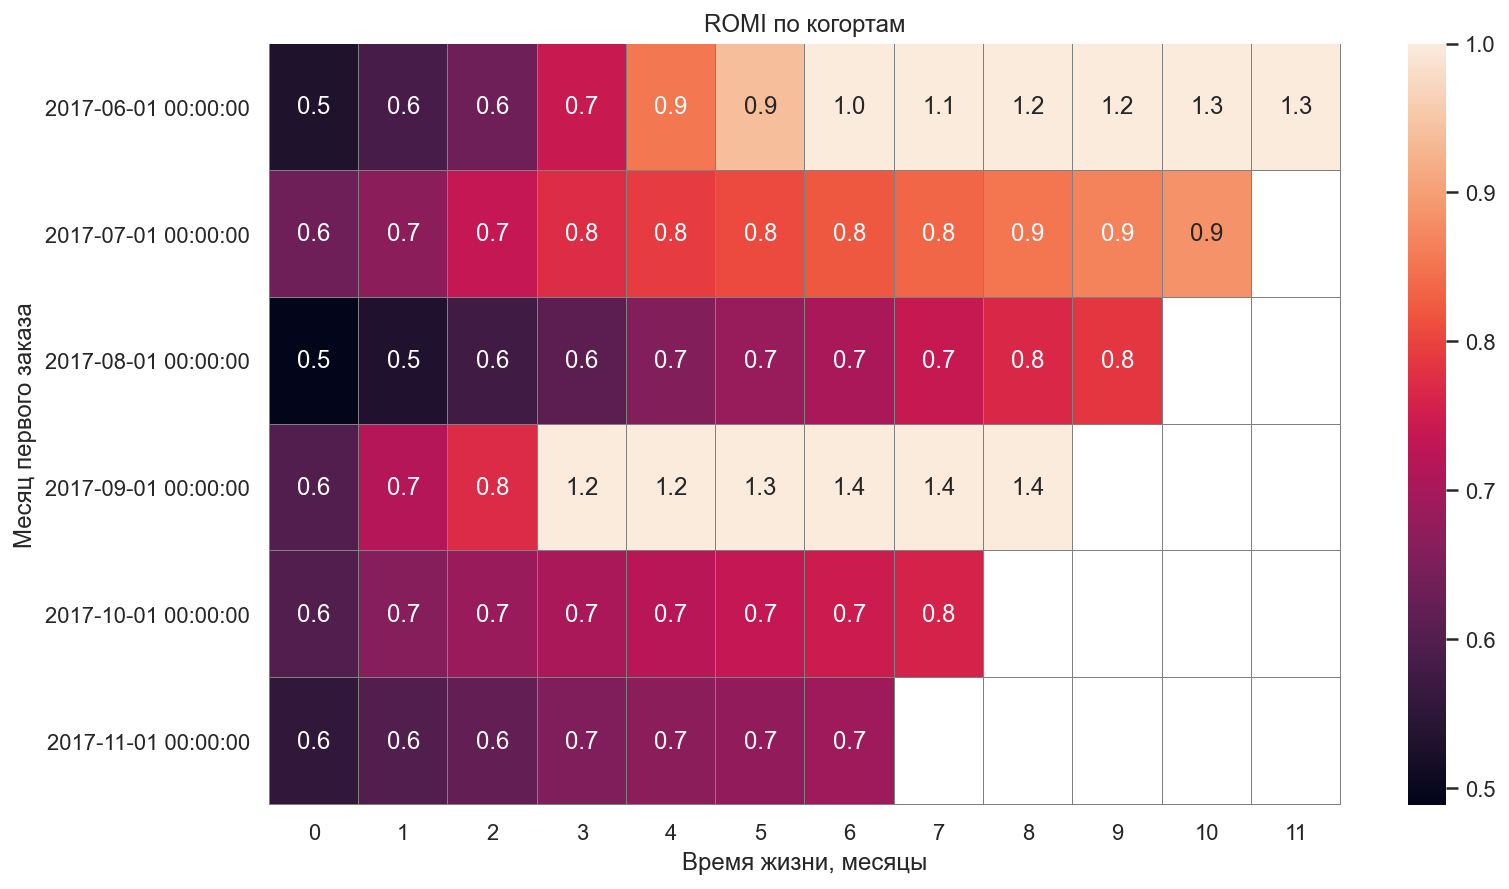

In [47]:
# Расчет помесячных расходов
monthly_costs = costs.groupby('month').sum()

# Добавление помесячных расходов в когортный отчет
romi_cohorts = pd.merge(ltv_cohorts, monthly_costs, left_on='first_month', right_on='month')

# Расчет CAC
romi_cohorts['cac'] = romi_cohorts['costs'] / romi_cohorts['cohort_size']

# Расчет ROMI
romi_cohorts['romi'] = romi_cohorts['ltv'] / romi_cohorts['cac']

# Построение сводной таблицы
romi_cohorts_pivot = romi_cohorts.pivot_table(
        index='first_month', 
        columns='cohort_lifetime', 
        values='romi', 
        aggfunc='mean')
# Подсчет накопленной суммы
romi_cohorts_pivot = romi_cohorts_pivot.cumsum(axis=1)

# Построение тепловой карты
print_heatmap(romi_cohorts_pivot[romi_cohorts_pivot[6].notna()], 'ROMI по когортам', fmt='0.1f', vmax=1, x_name='Время жизни, месяцы', y_name='Месяц первого заказа')

* Здесь, как и при расчете LTV, на первом месте оказалась когорта сентября 2017 года: она вышла на окупаемость через 3 месяца. Причем заметен резкий скачок за один месяц. Возможно это было следствие какой-то маркетинговой кампании, привлекшей новых клиентов в данный период. 
* На втором месте идет самая старшая когорта (июня 2017 года): она окупилась через полгода.
* Остальные из рассматриваемых когорт пока не окупились

Посмотрим, на какой месяц настает (если настает) окупаемость сервиса. Чтобы это увидеть, возьмем среднюю ROMI по периодам. 

In [48]:
display(romi_cohorts.pivot_table(
        index='first_month', 
        columns='order_month', 
        values='romi', 
        aggfunc='mean')
        .cumsum(axis=1).mean(axis=0))

order_month
2017-06-01    0.530530
2017-07-01    0.609326
2017-08-01    0.597294
2017-09-01    0.651594
2017-10-01    0.703549
2017-11-01    0.721548
2017-12-01    0.789592
2018-01-01    0.770004
2018-02-01    0.775282
2018-03-01    0.795030
2018-04-01    0.788017
2018-05-01    0.795609
dtype: float64

К концу рассматриваемого периода ROMI так и не достигла 1, т.е. затраты на маркетинг пока не окупились.

#### Выводы по пункту 2.3. Маркетинг
* Всего на маркетинг потрачено значительно больше, чем было выручено: примерно 330 тыс. у.е. при обороте в 250 тыс. у.е.
* Больше всего денег потрачено на источник 3, далее идут источники 4, 5. Источник 2 и 1, которые дают наибольшую LTV, оказались только на четвертом и пятом местах по расходам на маркетинг. На источник 3 потрачено намного больше, чем выручено. В остальных случаях выручка находится на уровне с затратами.
* Затраты на маркетинг очень схожи с картиной посещаемости и заказов. Также прослеживается сезонность затрат. Затраты на маркетинг сильно коррелируют с посещаемость и заказами. Таким образом, падение посещаемости и заказов весной-летом может быть связана с недостаточным финансирование расходов на маркетинг.
* Среднее значение CAC равно 9. Наибольшая стоимость привлечения клиента - у источников 3 и 2.
* Быстрее всего окупилась когорта из источника 1: через 2 месяца. Позже окупились когорты 2, 9, 5. Когорты из источников 3, 4, 10 не окупились вовсе за рассматриваемое время жизни. Хуже всего показала себя когорта из источника 3: она не окупилась даже на половину.

## Шаг 3. Общий вывод<a class="anchor" id="h1_3"></a>
Исходя из полученных данных хотелось бы порекомендовать следующее:
* Перспективным видится источник 1: клиенты из данного источника показывают одну из самых высоких LTV, а также быстро окупаются (основано на данных по ROMI).
* Также можно посоветовать источники 2,5,9. Выручка по ним превышает затраты на маркетинг, затраты на эти источники окупились за 5-6 месяцев
* На источник 3 потрачено значительно больше денег, чем он отдал в виде выручки. Клиенты из данного источника не окупились даже на половину.
* Также источники 4 и 10 не окупились. Но их ROMI чуть меньше 1. Возможно при оптимизации затрат на них получится получить с клиентов из данных источников большую LTV и выйти на окупаемость.
* На источники 6 и 7 не было ничего потрачено, отдачи от них тоже не было. Стоит обратить внимание на это внимание, возможно стоит в них вложить небольшую сумму и посмотреть отдачу в будущем.
* Сезонность, наблюдаемая в посещяемости пользователей и заказах клиентов возможно связана с тем, что в соответствующие периоды также менялись затраты на маркетинг (основано на данных по корреляции затрат на маркитинг с посещаемостью и заказами).
* При среднем чеке равным 5 и CAC=9 клиенту нужно совершить хотя бы 2 покупки, чтобы окупиться.
* Устройства типа desktop занимают значительную часть от всех посещений пользователей (порядка 73%). К сожалению, данных по продажам в разрезе устройств нет, и не удалось получить их на основе данных посещений. Исходя из данных посещений можно порекомендовать уделять веб-версии сервиса особое значение. Тем не менее, приложению на мобильных устройствах (touch) тоже важно развивать ввиду их популярности.
* Клиенты делают мало повторных покупок. Это означает, что сервис при такой динамике может развиваться только экстенсивно, т.е. за счет новых клиентов, а не удержания старых. Такой вариант развития достаточно ограничен из-за того, что ограничено количество потенциальных клиентов.
* Когортный анализ показал, что следует подробнее посмотреть историю клиентов следующих когорт:
    * самая старшая когорта (июнь 2017 года) - данная когорта вышла на окупаемость за полгода и стабильно показывает рост LTV. Т.е. клиенты из данной когорты стабильно совершают новые покупки
    * когорта сентября 2017 года - данную когорту следует рассмотреть подробнее с целью определить факторы, которые поспособствовали такой быстрой окупаемости когорты (за 3 месяца).
